In [1]:
%matplotlib inline

In [34]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.interpolate import griddata
from scipy.stats import gaussian_kde, pearsonr, spearmanr, ttest_ind
from scipy.spatial.distance import euclidean, cdist

from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import haversine_distances

# Study of the Effects of ENSO on Tropical Depressions in the North Pacific Ocean

## ABSTRACT

The El Niño-Southern Oscillation (ENSO) is a critical driver of climate variability, with profound impacts on weather patterns across the globe, particularly in the North Pacific Ocean. This study investigates the influence of ENSO phases—El Niño, La Niña, and Neutral on the formation, frequency, intensity, and tracks of tropical depressions (TD) in the North Pacific Ocean. Utilizing historical sea surface temperature (SST) data and tropical depression records, the study employs statistical analysis and geospatial techniques to explore correlations between ENSO phases and tropical depression activity.

The analysis reveals significant variations in the frequency and intensity of tropical depressions across different ENSO phases, with El Niño years showing a higher frequency of intense tropical depressions in the Central and Eastern Pacific, while La Niña years are associated with a westward shift in tropical depression activity towards the Western Pacific. The study also examines the changes in SST anomalies during different ENSO phases and their relationship with tropical depression formation.

These findings provide a deeper understanding of the complex interactions between ENSO and tropical depression dynamics in the North Pacific, offering valuable insights for improving the prediction and management of tropical depressions in the context of ENSO-driven climate variability. The results have significant implications for forecasting, disaster preparedness, and climate adaptation strategies in regions affected by tropical depressions.

## Introduction

### El Niño Southern Oscillation

The El Niño–Southern Oscillation is a single climate phenomenon that periodically fluctuates between three phases: Neutral, La Niña or El Niño. La Niña and El Niño are opposite phases in the oscillation which are deemed to occur when specific ocean and atmospheric conditions are reached or exceeded.

**El Niño** is the phase where the ocean waters in the central and eastern Pacific become warmer than usual. This warming can cause significant changes in weather patterns, such as increased rainfall in some areas and droughts in others.

**La Niña** is the opposite phase, where the ocean waters in these regions become cooler than average. This cooling also disrupts typical weather patterns, often leading to different sets of extremes, like more intense storms or colder temperatures in certain areas.

**Neutral** refers to the periods between El Niño and La Niña when sea surface temperatures are closer to their average, and global weather patterns are generally more stable.

ENSO is one of the most important drivers of climate variability on Earth, affecting everything from rainfall and temperatures to the occurrence of natural disasters like floods, droughts, and storms. Information on the phases and temperature deviations can be found in the [NOAA](https://origin.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/ONI_v5.php) website.  Warm and cold periods are calculated based on a threshold of $\pm0.5^oC $ for the Oceanic Niño Index (ONI) in the area of $5^oN-5^oS, 170^oW-120^oW$ (red rectangle).
On average, the period starts July-August and peaks November-January. 

Below diagrams showing the **SST** (sea surface temperature) of the ocean during peak of each ENSO phase. The data is obtained from [NASA Earth Data](https://www.earthdata.nasa.gov/topics/ocean/ocean-temperature/sea-surface-temperature) website. In order to keep the focus on th study, detailed explanation on the engine behind ENSO can be found at [Climate Prediction Center](https://origin.cpc.ncep.noaa.gov/products/precip/CWlink/MJO/enso.shtml#history) website.

In [3]:
def get_dataframe(path):
    """
    Reads a CSV file into a Pandas DataFrame and converts the index to datetime format.

    Parameters:
        path (str): The file path of the CSV to read.
    Returns:
        DataFrame: A Pandas DataFrame with the index converted to datetime.
    """
    df = pd.read_csv(path, index_col=0)
    df.index = pd.to_datetime(df.index)

    return df


def plot_equatorial_pacific(path, cond_name, plot_type='cnt', vmin=None, vmax=None):
    """
    Plots sequential months of Sea Surface Temperature (SST) data for the equatorial Pacific Ocean, 
    with each month's data displayed on a separate subplot. The user can choose between a contour map 
    or scatter plot for visualization.

    Parameters:
        path (str): Path to the CSV file containing SST data.
        cond_name (str): The name of the event to be plotted (e.g., "El Niño", "La Niña").
        plot_type (str): The type of plot to create, either contour map ['cnt'] (default) or scatter plot ['sct'].
        vmin (float, optional): The minimum scale value for the temperature color range. Defaults to the minimum SST value in the data.
        vmax (float, optional): The maximum scale value for the temperature color range. Defaults to the maximum SST value in the data.
    Returns:
        None: Displays the subplots showing SST data for each month.
    """
    df = get_dataframe(path)

    grouped_df = df.groupby(df.index)

    # Determine the number of subplots (one for each unique date)
    subplot_count = len(grouped_df)

    # Create subplots in a single row
    fig, axs = plt.subplots(1, subplot_count, figsize=(15 * subplot_count, 8))

    # If only one subplot, axs will not be an array, so we convert it to one
    if subplot_count == 1:
        axs = [axs]

    # Determine the common range for the color scale
    all_sst_values = df['sst'].values

    if vmin is None or vmax is None:
        vmin, vmax = np.min(all_sst_values), np.max(all_sst_values)

    for i, (date, data) in enumerate(grouped_df):

        if plot_type == 'sct':
            subplot = axs[i].scatter(data.lon, data.lat, c=data.sst, cmap='jet', alpha=0.7, s=150, vmin=vmin, vmax=vmax)

        else:
            lon_grid = np.linspace(data.lon.min(), data.lon.max(), 100)
            lat_grid = np.linspace(data.lat.min(), data.lat.max(), 100)
            lon_grid, lat_grid = np.meshgrid(lon_grid, lat_grid)
            sst_grid = griddata((data.lon, data.lat), data.sst, (lon_grid, lat_grid), method='linear')

            subplot = axs[i].contourf(lon_grid, lat_grid, sst_grid, cmap='jet', levels=20, vmin=vmin, vmax=vmax)

        fig.colorbar(subplot, ax=axs[i], label='Temperature')

        x_tick = np.arange(130, 290, 10)
        x_label = [f'{x}°E' if x <= 180 else f'{360 - x}°W' for x in x_tick]

        y_tick = np.arange(-20, 25, 5)
        y_label = [f'{np.abs(x)}°S' if x < 0 else f'{np.abs(x)}°N' for x in y_tick]

        axs[i].add_patch(plt.Rectangle((190, -5), 50, 10, linewidth=2, edgecolor='red', facecolor='none'))

        axs[i].axhline(y=0)

        axs[i].set_xticks(ticks=x_tick)
        axs[i].set_xticklabels(labels=x_label)

        axs[i].set_yticks(ticks=y_tick)
        axs[i].set_yticklabels(labels=y_label)

        axs[i].set_xlim(130, 280)
        axs[i].set_ylim(-20, 20)
        axs[i].set_xlabel('Longitude')
        axs[i].set_ylabel('Latitude')
        axs[i].set_title(f'{cond_name} SST for {pd.to_datetime(date).strftime("%B %Y")}')

    plt.tight_layout()
    plt.show()

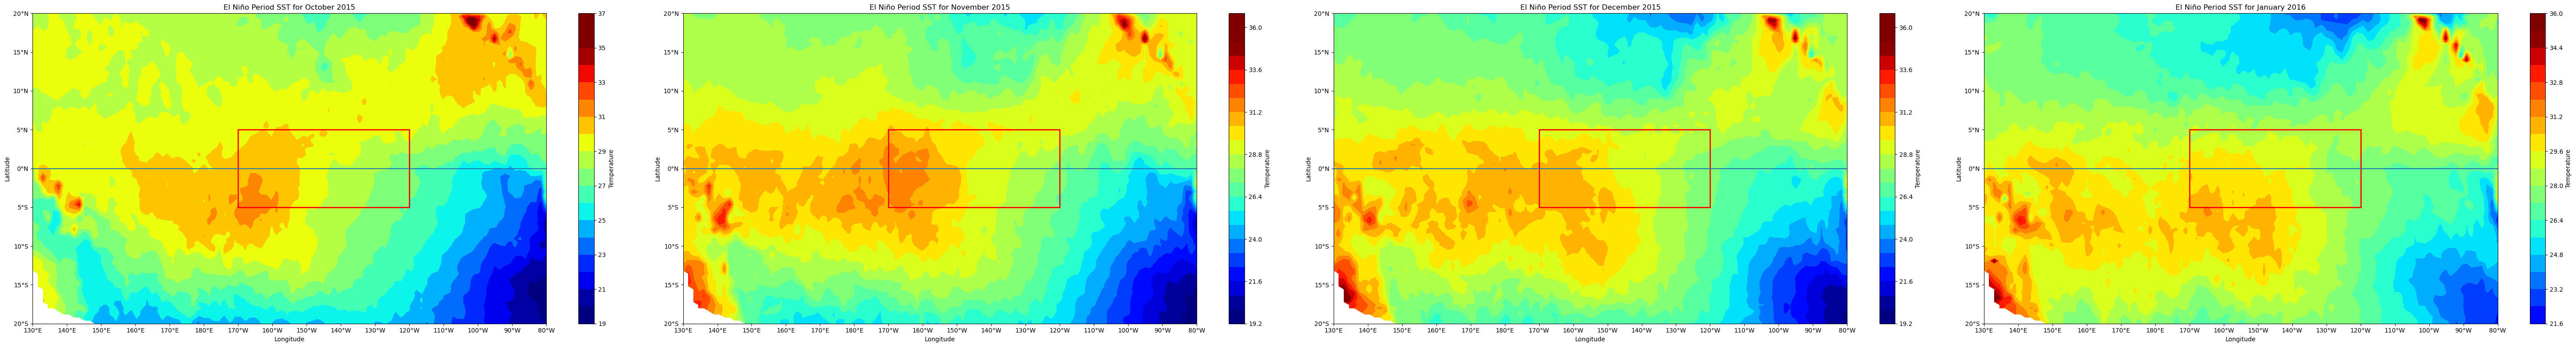

In [4]:
plot_equatorial_pacific(path='data/csv_ready/elnino_2015.csv', cond_name='El Niño Period', vmin=20, vmax=35)

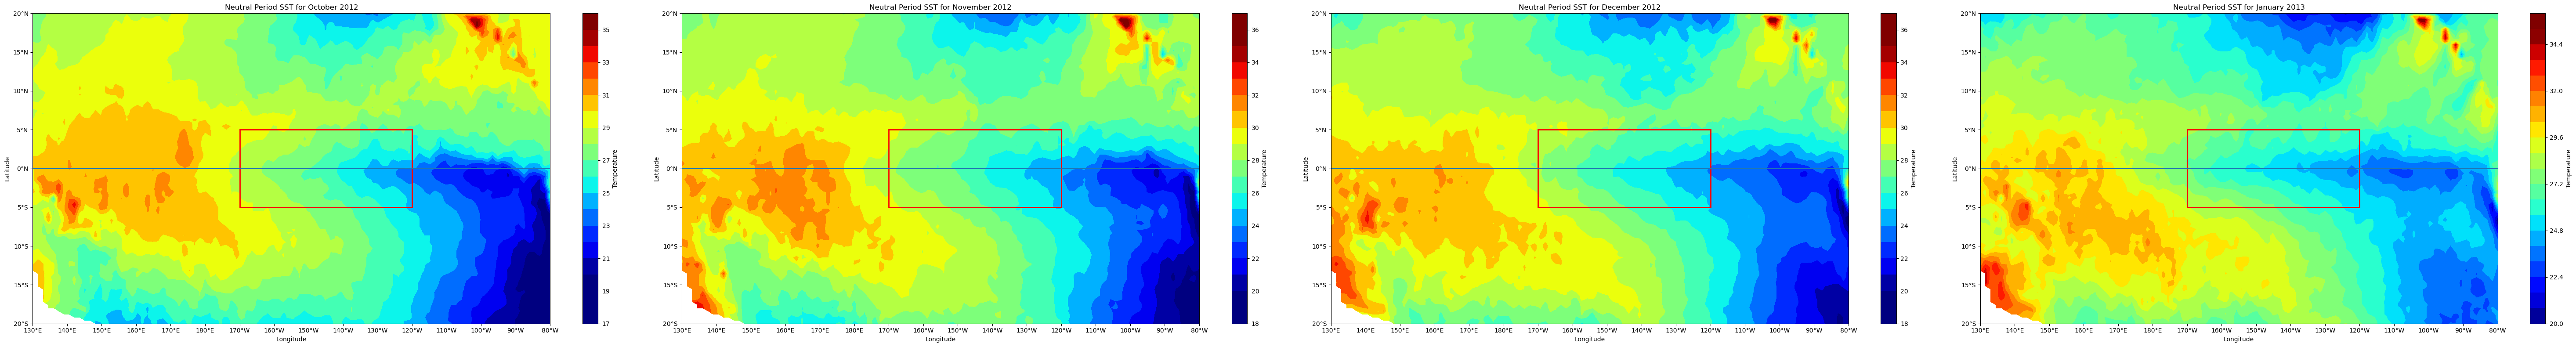

In [5]:
plot_equatorial_pacific('data/csv_ready/neutral_2012.csv', 'Neutral Period', vmin=20, vmax=35)

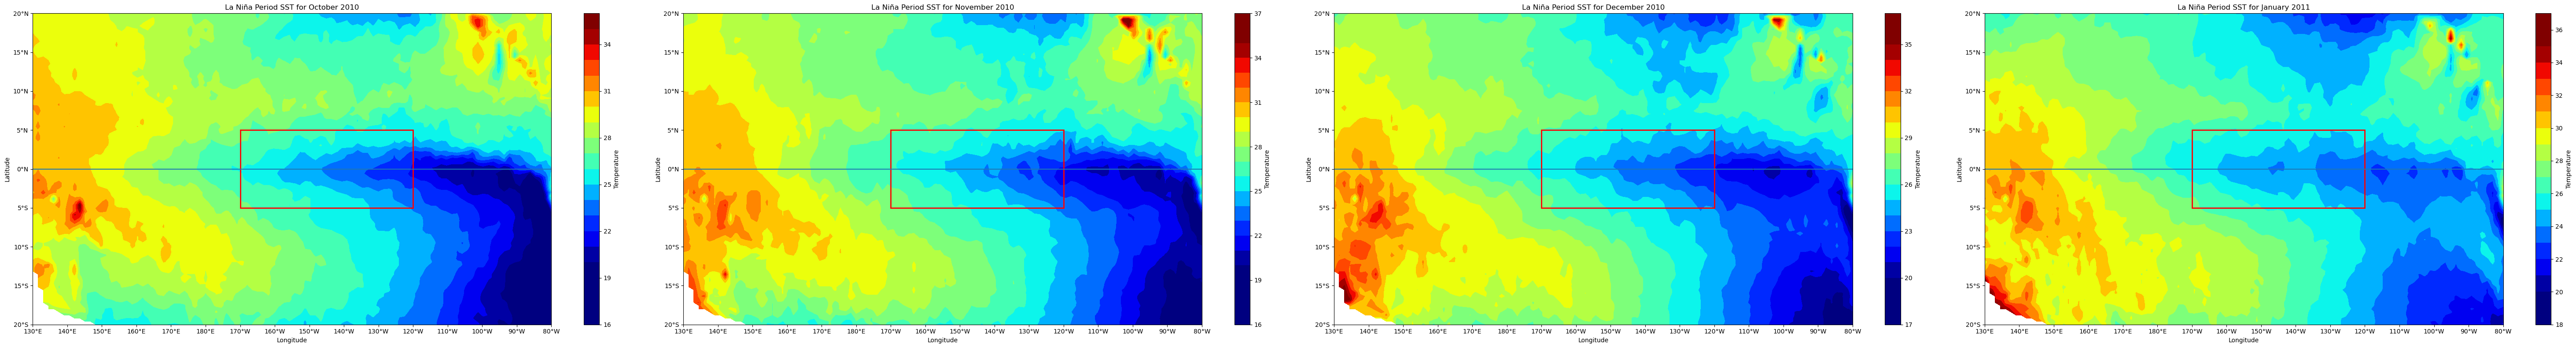

In [6]:
plot_equatorial_pacific('data/csv_ready/lanina_2010.csv', 'La Niña Period', vmin=20, vmax=35)

In [7]:
def get_dataframes():
    """
    Returns a list of base dataframes
    """
    la_nina = get_dataframe('data/csv_ready/lanina_2010.csv')
    neutral = get_dataframe('data/csv_ready/neutral_2012.csv')
    el_nino = get_dataframe('data/csv_ready/elnino_2015.csv')

    return [el_nino, neutral, la_nina]

def get_colors(index=None):
    """
    Returns a list of colors or a specific color based on the provided index.

    Parameters:
        index (int, optional): The index corresponding to the color. If None, returns the full list of colors.
                               Defaults to None.
    Returns:
        list or str: A list of colors ['r', 'g', 'b'] if index is None, or a specific color if an index is provided.
    """
    colors = ['r', 'g', 'b']
    if index is None:
        return colors
    return colors[index]

def get_ocean_area_label(index=None):
    """
    Returns a list of ocean area labels or a specific label based on the provided index.

    Parameters:
        index (int, optional): The index corresponding to the ocean area label. If None, returns the full list of labels.
                               Defaults to None.
    Returns:
        list or str: A list of ocean area labels ['NW', 'Central and NE'] if index is None, or a specific label 
                     if an index is provided.
    """
    ocean_area = ['NW', 'Central and NE']
    if index is None:
        return ocean_area
    return ocean_area[index]

def get_phase_label(phase=None):
    """
    Returns a list of ENSO phase labels or a specific label based on the provided phase index.

    Parameters:
        phase (int, optional): The index corresponding to the ENSO phase (-1 for La Niña, 0 for Neutral, 1 for El Niño).
                               If None, returns the full list of labels. Defaults to None.
    Returns:
        list or str: A list of ENSO phase labels ['La Niña', 'Neutral', 'El Niño'] if phase is None, 
                     or a specific label if a phase index is provided.
    """
    labels = ['La Niña', 'Neutral', 'El Niño']
    if phase is None:

        return labels
    return labels[phase]

def get_enso_colors(phase=None):
    """
    Returns the color corresponding to a given ENSO phase key, or the entire color mapping dictionary if no phase is provided.

    Parameters:
        phase (int, optional): The key representing the ENSO phase (-1 for La Niña, 0 for Neutral, 1 for El Niño).
                               If None, returns the entire color mapping dictionary. Defaults to None.
    Returns:
        str or dict: The color associated with the given phase ('blue' for La Niña, 'green' for Neutral, 'red' for El Niño),
                     or the full dictionary of ENSO colors if no phase is provided.
    """
    colors_mapper = {-1: 'blue', 0: 'green', 1: 'red'}
    return colors_mapper.get(phase, colors_mapper)

def get_enso_months(index=None):
    """
    Returns a list of ENSO-related months or a specific month based on the provided index.

    Parameters:
        index (int, optional): The index corresponding to a specific month. If None, returns the full list of months.
                               Defaults to None.
    Returns:
        list or str: A list of months ['October', 'November', 'December', 'January'] if index is None,
                     or a specific month if an index is provided.
    """
    months = ['October', 'November', 'December', 'January']

    if index is None:
        return months

    return months[index]

def get_cmaps(key=None):
    """
    Returns the colormap corresponding to a given ENSO phase key, or the entire colormap dictionary if no key is provided.

    Parameters:
        key (int, optional): The key representing the ENSO phase (-1 for La Niña, 0 for Neutral, 1 for El Niño). 
                             If None, returns the entire colormap dictionary. Defaults to None.
    Returns:
        str or dict: The colormap name associated with the given key ('Blues' for La Niña, 'Greens' for Neutral, 'Reds' for El Niño),
                     or the full dictionary of colormaps if no key is provided.
    """
    cmaps = {-1: 'Blues', 0: 'Greens', 1: 'Reds'}
    return cmaps.get(key, cmaps)

def get_phase_names(key=None):
    """
    Returns the name of the ENSO phase corresponding to a given key, or the entire phase dictionary if no key is provided.

    Parameters:
        key (int, optional): The key representing the ENSO phase (-1 for La Niña, 0 for Neutral, 1 for El Niño).
                             If None, returns the entire phase dictionary. Defaults to None.
    Returns:
        str or dict: The name of the ENSO phase ('La Niña', 'Neutral', or 'El Niño') corresponding to the given key,
                     or the full dictionary of phase names if no key is provided.
    """
    phases = {-1: 'La Niña', 0: 'Neutral', 1: 'El Niño'}
    return phases.get(key, phases)
    
def plot_sst_difference(dfs):
    """
    Plots the Sea Surface Temperature (SST) difference for different ENSO phases over specific months.
    
    Parameters:
        dfs (list of DataFrames): A list of DataFrames containing SST data for different ENSO phases.
    Returns:
        None: Displays a line plot showing the SST differences for each ENSO phase over the months of October to January.
    """

    for i, df in enumerate(dfs):
        sst = df.groupby(df.index).sst.mean()
        plt.plot(get_enso_months(), sst, c=get_colors(i), label=get_phase_label(i))
    
    plt.ylim(26, 29)
    
    plt.legend()
    plt.xlabel('Months')
    plt.ylabel('SST in deg C')
    plt.title('Difference in the SST between El Niño, La Niña and Neutral Periods')
    
    plt.show()

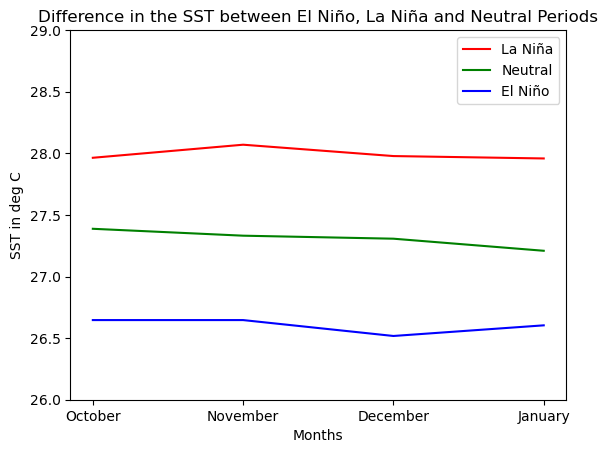

In [8]:
plot_sst_difference(get_dataframes())

The diagram above compares the mean temperature of the **El Niño Region**, shown as a red rectangle in the heatmaps. It is a visual representation of the mean temperature between different phases. The difference between the SST during El Niño/La Niña and Neutral phases is the **temperature anomaly** also known as **Oceanic Niño Index (ONI)**.

### Tropical Depressions (TD)

This project focuses on understanding how ENSO affects TDs in the North Pacific Ocean. TDs are low-pressure weather systems that can develop into more severe storms, such as tropical storms or hurricanes. By analyzing historical data on sea surface temperatures (SSTs) and TDs, this study aims to uncover patterns and relationships between the different phases of ENSO and the behavior of TDs in the Eastern, Central, and Western Pacific regions. Understanding these connections can help improve forecasts and prepare for the impacts of these powerful weather systems.

The season of the TDs in **Eastern and Central North Pacific** officially begins in mid-May (Eastern Pacific) or June 1st (Central Pacific) and ends on November 30th, with peak activity typically occurring from August to September. In **Western North Pacific**, unlike the Eastern and Central Pacific, has TDs occurring throughout the year. However, the most active period is from July to October, with a significant concentration of storms. 

Further info on the tropical cyclons, their forming and life cycle, can be found [here](https://en.wikipedia.org/wiki/Tropical_cyclone).

ENSO peaks in December and the conditions typically take several months to influence global weather patterns fully. Then the primary effects on tropical storms and depressions in the North Pacific would generally be observed during the summer and fall of the year to follow. Basis on the above assumption, the pahse of ENSO will be applied to the years from 1950 till now. The value of the ENSO column of the tables below will reflect the ENSO year phase. 1 - El Niño influenced year, 0 -Neutral year, -1 - La Niña influenced year. The phases depend on whether ONI is greater than 0.5, less than -0.5, or between -0.5 and 0.5.

## Data in the Project

### Data Sources

The data used in this project comes from multiple reputable sources, ensuring comprehensive coverage of both tropical depression (TD) activity and environmental factors like sea surface temperature (SST) anomalies:

The SST anomaly data was obtained from the NASA Earth Data AQUA MODIS satellite, providing high-resolution sea surface temperature measurements. These anomalies reflect deviations from normal sea temperatures, which are critical for understanding the effects of El Niño and La Niña events. The data is in .nc format

Data for tropical depressions in the Northwest Pacific was sourced from the Japan Meteorological Agency (JMA). This dataset includes information on each tropical depression's intensity, minimum pressure, wind speeds, latitude, and longitude.

The National Hurricane Center (NHC) provided tropical depression data for the Northeast and Central Pacific, which is similar to the JMA data in terms of recorded metrics like wind speed, pressure, and storm tracks.

The ENSO phases (El Niño, La Niña, and Neutral) were derived from the ONI table provided by the Climate Prediction Center (CPC). The ONI is calculated as the rolling three-month mean SST anomaly in the Niño 3.4 region and is commonly used to identify ENSO phases.

The GSHHS (Global Self-consistent, Hierarchical, High-resolution Shoreline Database) was also utilized in this project to provide accurate geographical boundaries and coastlines for visualizing tropical depression tracks. This dataset offers detailed representations of global shorelines, which are essential for plotting storm trajectories in relation to landmasses and understanding potential landfall locations. GSHHS data ensures that the geospatial analysis of tropical depressions remains accurate and visually consistent when overlaying storm tracks on global maps.

### Data Cleaning and Tidying:

To ensure the integrity and usability of the datasets, various cleaning and preprocessing steps were applied. Any missing or erroneous data points (e.g., pressure or wind speed values) were removed from the dataset to avoid inaccuracies in the analysis. Wind speed and pressure measurements from different sources were standardized to the same units across datasets. All datasets were unified with consistent date and time formats to facilitate accurate time-series analysis. Timestamp irregularities were resolved to ensure consistent time intervals. Data was grouped by year and ENSO phase for analysis, with yearly and monthly aggregation of tropical depression characteristics (frequency, intensity, and duration). In occasion, the ONI data was lagged to ensure proper correlation with TD activity in subsequent seasons.

These preprocessing steps ensured that the datasets were clean, consistent, and ready for statistical analysis, which helped in understanding the relationships between ENSO phases and tropical depression activity across the Pacific regions. Full code is available in the attached .py files for technical implementation details.

## Impact and Broader Importance of the Problem

The study of the effects of the El Niño-Southern Oscillation (ENSO) on tropical depressions (TDs) in the North Pacific Ocean is critical for several reasons:

- Improved Forecasting and Disaster Preparedness:
Tropical depressions, which can evolve into tropical storms and typhoons, pose significant risks to coastal communities, maritime activities, and economies in the Pacific region. By understanding how ENSO phases (El Niño, La Niña, and Neutral) influence the frequency, intensity, and tracks of tropical depressions, meteorologists and climate scientists can improve their forecasting models. This enables governments and disaster management agencies to better prepare for the impacts of extreme weather, reducing loss of life and economic damages.

- Economic and Human Impact:
The Pacific Ocean region, particularly areas like Japan, the Philippines, Hawaii, and the west coast of North America, regularly faces destructive storms. Knowing how different ENSO phases affect storm development can provide early warnings for industries like agriculture, fishing, and tourism, which are highly susceptible to tropical storm impacts. Reliable predictions can help minimize disruptions and protect vital industries.

- Climate Change Insights:
The relationship between ENSO and tropical storm activity can also offer insights into how climate change might influence future weather patterns. If the intensity or frequency of El Niño or La Niña events increases due to global warming, this could alter tropical depression patterns. Understanding these shifts can help climate scientists predict future weather risks and inform global climate policy and adaptation strategies.


- Regional Security and Infrastructure Planning:
The ability to anticipate where and when tropical depressions will occur, and their intensity, is vital for infrastructure planning, particularly in vulnerable regions. Coastal defenses, urban planning, and resource management can be optimized with better knowledge of how ENSO affects tropical weather patterns. This also impacts regional security, as extreme weather events can displace populations and strain emergency services.

- Environmental Impact:
Tropical depressions influence ocean currents, marine ecosystems, and coastal environments. Shifts in storm patterns due to ENSO phases can affect marine biodiversity, coral reef health, and fisheries. Understanding these relationships helps in managing natural resources and protecting marine ecosystems that are crucial to sustaining livelihoods in the region.
In summary, the broader importance of this research lies in its potential to enhance climate resilience, improve disaster risk management, and contribute to our understanding of the complex interactions between oceanic and atmospheric systems, particularly in the context of climate variability and change.

## Establishing Hypotheses
**Hypothesis 1**: ENSO and Frequency of Tropical Depressions

- Null Hypothesis $H_0$: There is **no significant difference** in the frequency of tropical depressions across different ENSO phases (El Niño, La Niña, Neutral).
- Alternative Hypothesis $H_1$: There **is a significant difference** in the frequency of tropical depressions across different ENSO phases.

**Hypothesis 2**: ENSO and Intensity of Tropical Depressions

- Null Hypothesis $H_0$: ENSO phases **do not** significantly affect the intensity of tropical depressions (measured by metrics such as maximum wind speed or minimum central pressure).
- Alternative Hypothesis $H_1$: ENSO phases significantly affect the intensity of tropical depressions.

**Hypothesis 3**: ENSO and Tropical Depressions tracks

- Null Hypothesis $H_0$: ENSO phases **do not** significantly affect the track of tropical depressions.
- Alternative Hypothesis $H_1$: ENSO phases significantly affect the track of tropical depressions.

**Hypothesis 4**: ENSO and Tropical Depressions duration

- Null Hypothesis $H_0$: ENSO phases **do not** significantly affect the duration of tropical depressions.
- Alternative Hypothesis $H_1$: ENSO phases significantly affect the duration of tropical depressions.


The hypotheses will be applied separately for TDs in NW and Central/NE Pacific Ocean

## Exploratory Data Analysis (EDA)
In the context of studying the effects of ENSO on TDs in the North Pacific Ocean, EDA will involve temporal, geospatial, and intensity analysis.

### Temporal Analysis
This analysis will be used to understand how the frequency of TDs varies over time and how this is influenced by different ENSO phases. Additionally, this analysis will explore how sea surface temperature (SST) anomalies correlate with these variations. We start by calculating the frequency of a TD per calendar year. Frequency values are calculated by counting the number of occurrences of tropical depressions within a specific time frame, such as annually. It will help to quantify how active a particular year or ENSO phase was in terms of tropical depression formation.

In [9]:
# load various data. in order to read the data only once, the code is not grouped in a function
oni_table = pd.read_csv('data/csv_ready/oni_table.csv', index_col=0)
oni_temp = pd.read_csv('data/csv_ready/oni_temp.csv', index_col=0)
oni_table.index = pd.to_datetime(oni_table.index)
enso_phase = oni_table.groupby(oni_table.index.year)['enso'].apply(lambda x: x.unique()[0])

jma = pd.read_csv('data/csv_ready/jma_td.csv', index_col=0)
jma.index = pd.to_datetime(jma.index)
frequency_jma = jma.groupby(jma.index.year)['name'].nunique()
frequency_jma = pd.merge(frequency_jma, enso_phase, on='date')
frequency_jma.columns = ['frequency', 'enso']

nhc = pd.read_csv('data/csv_ready/ne_pacific_td.csv', index_col=0)
nhc.index = pd.to_datetime(nhc.index)
frequency_nhc = nhc.groupby(nhc.index.year)['name'].nunique()
frequency_nhc = pd.merge(frequency_nhc,enso_phase, on='date')
frequency_nhc.columns = ['frequency', 'enso']

nhc_cp = nhc[nhc.basin == 'CP']
frequency_nhc_cp = nhc_cp.groupby(nhc_cp.index.year)['name'].nunique()
frequency_nhc_cp = pd.merge(frequency_nhc_cp,enso_phase, on='date')
frequency_nhc_cp.columns = ['frequency', 'enso']

nhc_ep = nhc[nhc.basin == 'EP']
frequency_nhc_ep = nhc_ep.groupby(nhc_ep.index.year)['name'].nunique()
frequency_nhc_ep = pd.merge(frequency_nhc_ep,enso_phase, on='date')
frequency_nhc_ep.columns = ['frequency', 'enso']

frequency_tables = [
    ('NW', frequency_jma), 
    ('Central', frequency_nhc_cp), 
    ('NE', frequency_nhc_ep)]

dfs_freq = [frequency_jma, frequency_nhc]

In [10]:
def plot_yearly_frequency(dfs):
    """
    Plots the yearly frequency of tropical depressions for different Pacific regions (NW, Central, NE)
    based on ENSO phases (La Niña, Neutral, El Niño). Each ENSO phase is represented by a different color, 
    and the frequency is displayed in a bar chart for each year.

    Parameters:
        dfs (list of tuples): A list of tuples where each tuple contains:
                              - A string representing the region (e.g., 'NW', 'Central', 'NE').
                              - A DataFrame with columns ['frequency', 'enso'] where 'frequency' is the number 
                                of tropical depressions in a given year, and 'enso' is the corresponding ENSO phase.
    Returns:
        None: Displays a bar plot for each region with ENSO phases represented by different colors.
    """
    labels = get_phase_label()
    colors = get_colors()
    
    fig, axs = plt.subplots(1, 3, figsize=(30, 8))
    
    for i, table in enumerate(dfs):
        for year, freq, enso in zip(table[1].index, table[1].frequency, table[1].enso):
            axs[i].bar(year, freq, color=get_enso_colors(enso))
        
        # Create the legend for ENSO phases
        rectangles = [plt.Rectangle((0,0),1,1, color=color) for color in colors]
        axs[i].legend(rectangles, labels, title='ENSO Phase', loc='upper left')
        
        axs[i].set_title(f'Frequency of Tropical Depressions, originating in the {table[0]} Pacific, by Year')
        axs[i].set_xlabel('Year')
        axs[i].set_ylabel('Number of Tropical Depressions')
        axs[i].set_xlim(1950, 2024)
        axs[i].set_ylim(0, 37)
    
    plt.show()

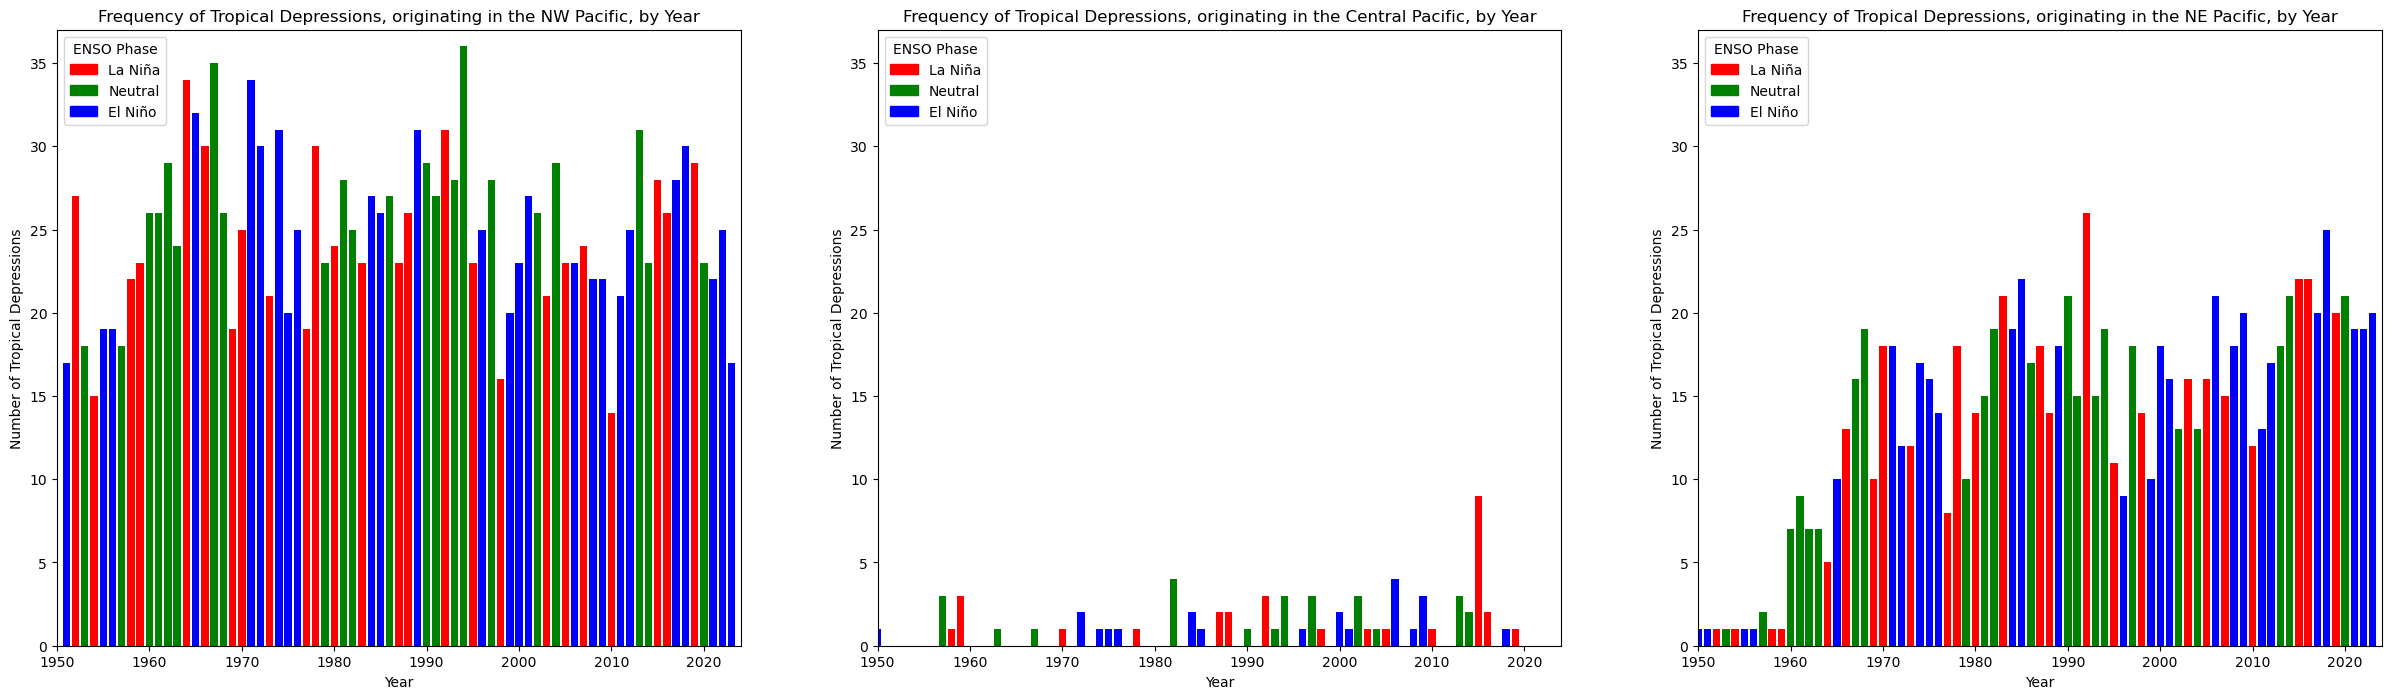

In [11]:
plot_yearly_frequency(frequency_tables)

In [12]:
def add_value_labels(ax, bars):
    """
    Adds value labels on top of each bar in a bar plot.

    Parameters:
        ax (Axes): The Matplotlib Axes object containing the bars.
        bars (BarContainer): The container of bars (from a bar plot) to annotate with values.
    Returns:
        None: Adds annotations to the plot directly.
    """
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

def plot_mean_frequency(dfs):
    """
    Plots the mean frequency of tropical depressions by ENSO phase for multiple datasets 
    and different Pacific Ocean regions. The mean frequency is calculated for each ENSO phase.

    Parameters:
        dfs (list of DataFrames): A list of DataFrames where each DataFrame contains the frequency 
                                  of tropical depressions and ENSO phase for a specific region.
    Returns:
        None: Displays a bar plot showing the mean frequency of tropical depressions by ENSO phase 
              for different regions of the Pacific.
    """
    labels = get_phase_label()
    ocean_area = get_ocean_area_label()
    
    mean_data = [[x for x in df.groupby(['enso']).frequency.mean()] for df in dfs]
    x_axis = np.arange(len(labels))

    # set the width of the bars
    width = 0.20

    fig, ax = plt.subplots(figsize=(10, 8))

    for i, df_data in enumerate(mean_data):
        x_values = (x_axis - width/2) if i == 0 else (x_axis + width/2)
        bars = ax.bar(x_values, df_data, width, label=f'{ocean_area[i]} Pacific')
        add_value_labels(ax, bars)
        
    ax.set_xlabel('ENSO Phase')
    ax.set_ylabel('Mean Frequency of Tropical Depressions')
    ax.set_title('Mean Frequency of Tropical Depressions by ENSO Phase')
    ax.set_xticks(x_axis)
    ax.set_xticklabels(labels)
    ax.legend()
    
    plt.show()

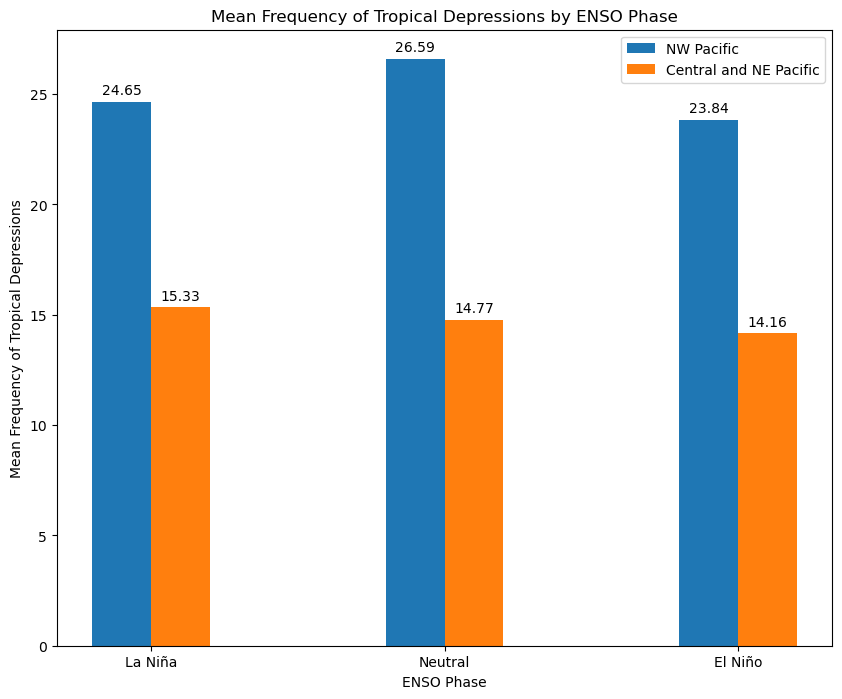

In [13]:
plot_mean_frequency(dfs_freq)

#### Mean Frequency Analysis for NW and Central/NE Pacific
1. *Frequency of Tropical Depressions in the Northwest Pacific (JMA Data)*:
**Neutral Influence**: The highest average frequency of tropical depressions is observed during Neutral years (26.59 TDs per year). The slightly higher frequency during Neutral years suggests that in the NW Pacific, tropical depression formation might be more consistent and less affected by extreme ENSO phases.
**La Niña Influence**: During La Niña years, the frequency is slightly lower at 24.65 TDs per year. La Niña years tend to slightly reduce the frequency of tropical depressions compared to Neutral years but are still more active than El Niño years.
**El Niño Influence**: The lowest frequency is observed during El Niño years, with 23.84 TDs per year. The reduced frequency during El Niño years aligns with the general understanding that El Niño conditions can shift tropical cyclone activity eastward, reducing activity in the NW Pacific.

2. *Frequency of Tropical Depressions in the Central and Northeast Pacific (NHC Data)*:
**La Niña Influence**: The highest average frequency is observed during La Niña years (15.33 TDs per year). The higher frequency during La Niña years suggests that La Niña conditions may enhance tropical depression formation in the Central and NE Pacific regions.
**Neutral Influence**: The frequency during Neutral years is slightly lower (14.77 TDs per year).
**El Niño Influence**: The lowest frequency is again observed during El Niño years (14.16 TDs per year). The reduced frequency during El Niño years is consistent with the general shift of tropical depression activity towards the Central and Eastern Pacific but might indicate that conditions during El Niño years are not as conducive for tropical depressions in these specific regions compared to La Niña years.

### Intensity Analysis
The goal of the intensity analysis is to determine how the intensity of tropical depressions varies across different ENSO phases. The intensity can be measured by various metrics, such as maximum wind speed or minimum central pressure. By analyzing these metrics, we assess whether certain ENSO phases are associated with stronger or weaker tropical depressions.

In [14]:
# Grouping by year and finding max wind and min press
jma_max_wind = jma.groupby([jma.index.year]).max_wind_kn.max()
nhc_max_wind = nhc.groupby([nhc.index.year]).max_wind_kn.max()

jma_min_press = jma.groupby([jma.index.year]).min_pressure_mBar.min()
nhc_min_press = nhc.groupby([nhc.index.year]).min_pressure_mBar.min()

jma_max_wind = pd.merge(jma_max_wind, enso_phase, on='date')
jma_max_wind.max_wind_kn = jma_max_wind.max_wind_kn.apply(lambda x: None if x == 0 else x)
jma_max_wind = jma_max_wind.dropna()
nhc_max_wind = pd.merge(nhc_max_wind, enso_phase, on='date')

jma_min_press = pd.merge(jma_min_press, enso_phase, on='date')
nhc_min_press = pd.merge(nhc_min_press, enso_phase, on='date')
nhc_min_press.min_pressure_mBar = nhc_min_press.min_pressure_mBar.apply(lambda x: None if x < 0 else x)
nhc_min_press = nhc_min_press.dropna()

In [15]:
# statistics
def extract_stats(df):
    df = df.groupby(['enso']).describe().T
    df = df.reset_index()
    df = df.drop(columns='level_0')
    df = df.pivot_table(columns='level_1')

    return df
    
array_of_data = [jma_max_wind, nhc_max_wind, jma_min_press, nhc_min_press]
jma_max_wind_stats = extract_stats(jma_max_wind)
nhc_max_wind_stats = extract_stats(nhc_max_wind)
jma_min_press_stats = extract_stats(jma_min_press)
nhc_min_press_stats = extract_stats(nhc_min_press)

In [16]:
# function to plot the boxplot and tables
def plot_boxplot_and_table(dataset_array, tables_array, col_name, title, ylim=None):
    """
    Plots boxplots for a specified column across different ENSO phases (La Niña, Neutral, El Niño) 
    for different Pacific regions, along with corresponding statistical tables. 

    Parameters:
        dataset_array (list of DataFrames): A list of DataFrames where each DataFrame contains data for a specific Pacific region.
        tables_array (list of DataFrames): A list of DataFrames containing statistical summary data (mean, std, etc.) 
                                           for each ENSO phase corresponding to the datasets.
        col_name (str): The column name for which to create the boxplots (e.g., wind speed, pressure).
        title (str): The title for the boxplots.
        ylim (tuple, optional): A tuple specifying the y-axis limits for the boxplots (e.g., (0, 50)). 
                                Defaults to None (no limit).

    Returns:
        None: Displays the boxplots and corresponding tables for the different Pacific regions.
    """
    labels = get_phase_label()
    ocean_area = get_ocean_area_label()
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))
    
    for i, df in enumerate(dataset_array):
        axs[0][i].boxplot([df[df['enso'] == -1][col_name],
                         df[df['enso'] == 0][col_name],
                         df[df['enso'] == 1][col_name]],
                         labels=labels)
        axs[0][i].set_title(f'{title} by ENSO Phase for {ocean_area[i]} Pacific')
        axs[0][i].set_xlabel('ENSO Phase')
        axs[0][i].set_ylabel(title)
        if not ylim is None:
            axs[0][i].set_ylim(ylim)
    
    for i, dt in enumerate(tables_array):
        axs[1][i].axis('tight')
        axs[1][i].axis('off')
        axs[1][i].table(cellText=dt.values.round(1),
                     colLabels=dt.columns,
                     rowLabels=labels,
                     cellLoc='center', loc='center')
    
    plt.tight_layout()
    plt.show()

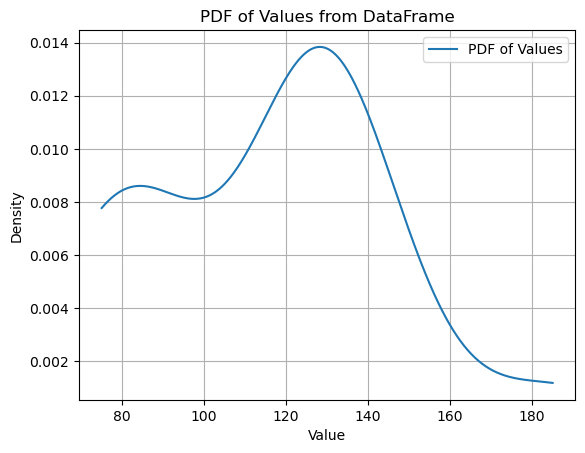

In [17]:
values = nhc_max_wind.max_wind_kn[nhc_max_wind.enso == 1]
pdf = gaussian_kde(values)

# Generate a range of values for the x-axis
x = np.linspace(min(values), max(values), 1000)

# Plot the PDF
plt.plot(x, pdf(x), label='PDF of Values')

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('PDF of Values from DataFrame')

# Show the plot
plt.legend()
plt.grid(True)
plt.show()

<Axes: xlabel='max_wind_kn', ylabel='Density'>

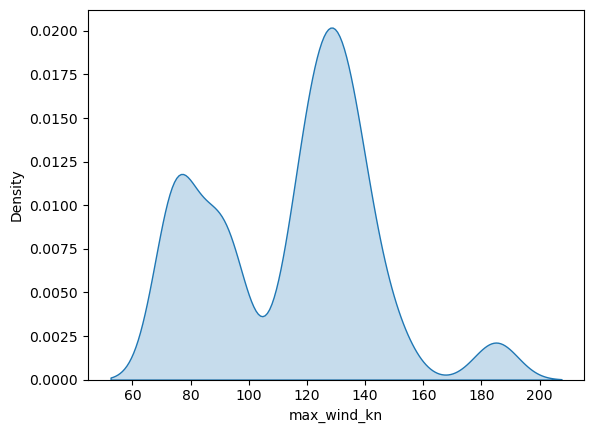

In [18]:
sns.kdeplot(values, bw_adjust=0.5, fill=True, label='PDF of Values')

In [19]:
nhc_max_wind.max_wind_kn[nhc_max_wind.enso == 0]

date
1953     75.0
1957    120.0
1960     75.0
1961     75.0
1962     75.0
1963     75.0
1967    130.0
1968     75.0
1979    125.0
1981    110.0
1982    125.0
1986    125.0
1990    135.0
1991    125.0
1993    130.0
1994    150.0
1997    160.0
2002    145.0
2004    130.0
2013    110.0
2014    140.0
2020    120.0
Name: max_wind_kn, dtype: float64

In [20]:
nhc_max_wind.max_wind_kn[nhc_max_wind.enso == -1].skew()

-0.9287306977095883

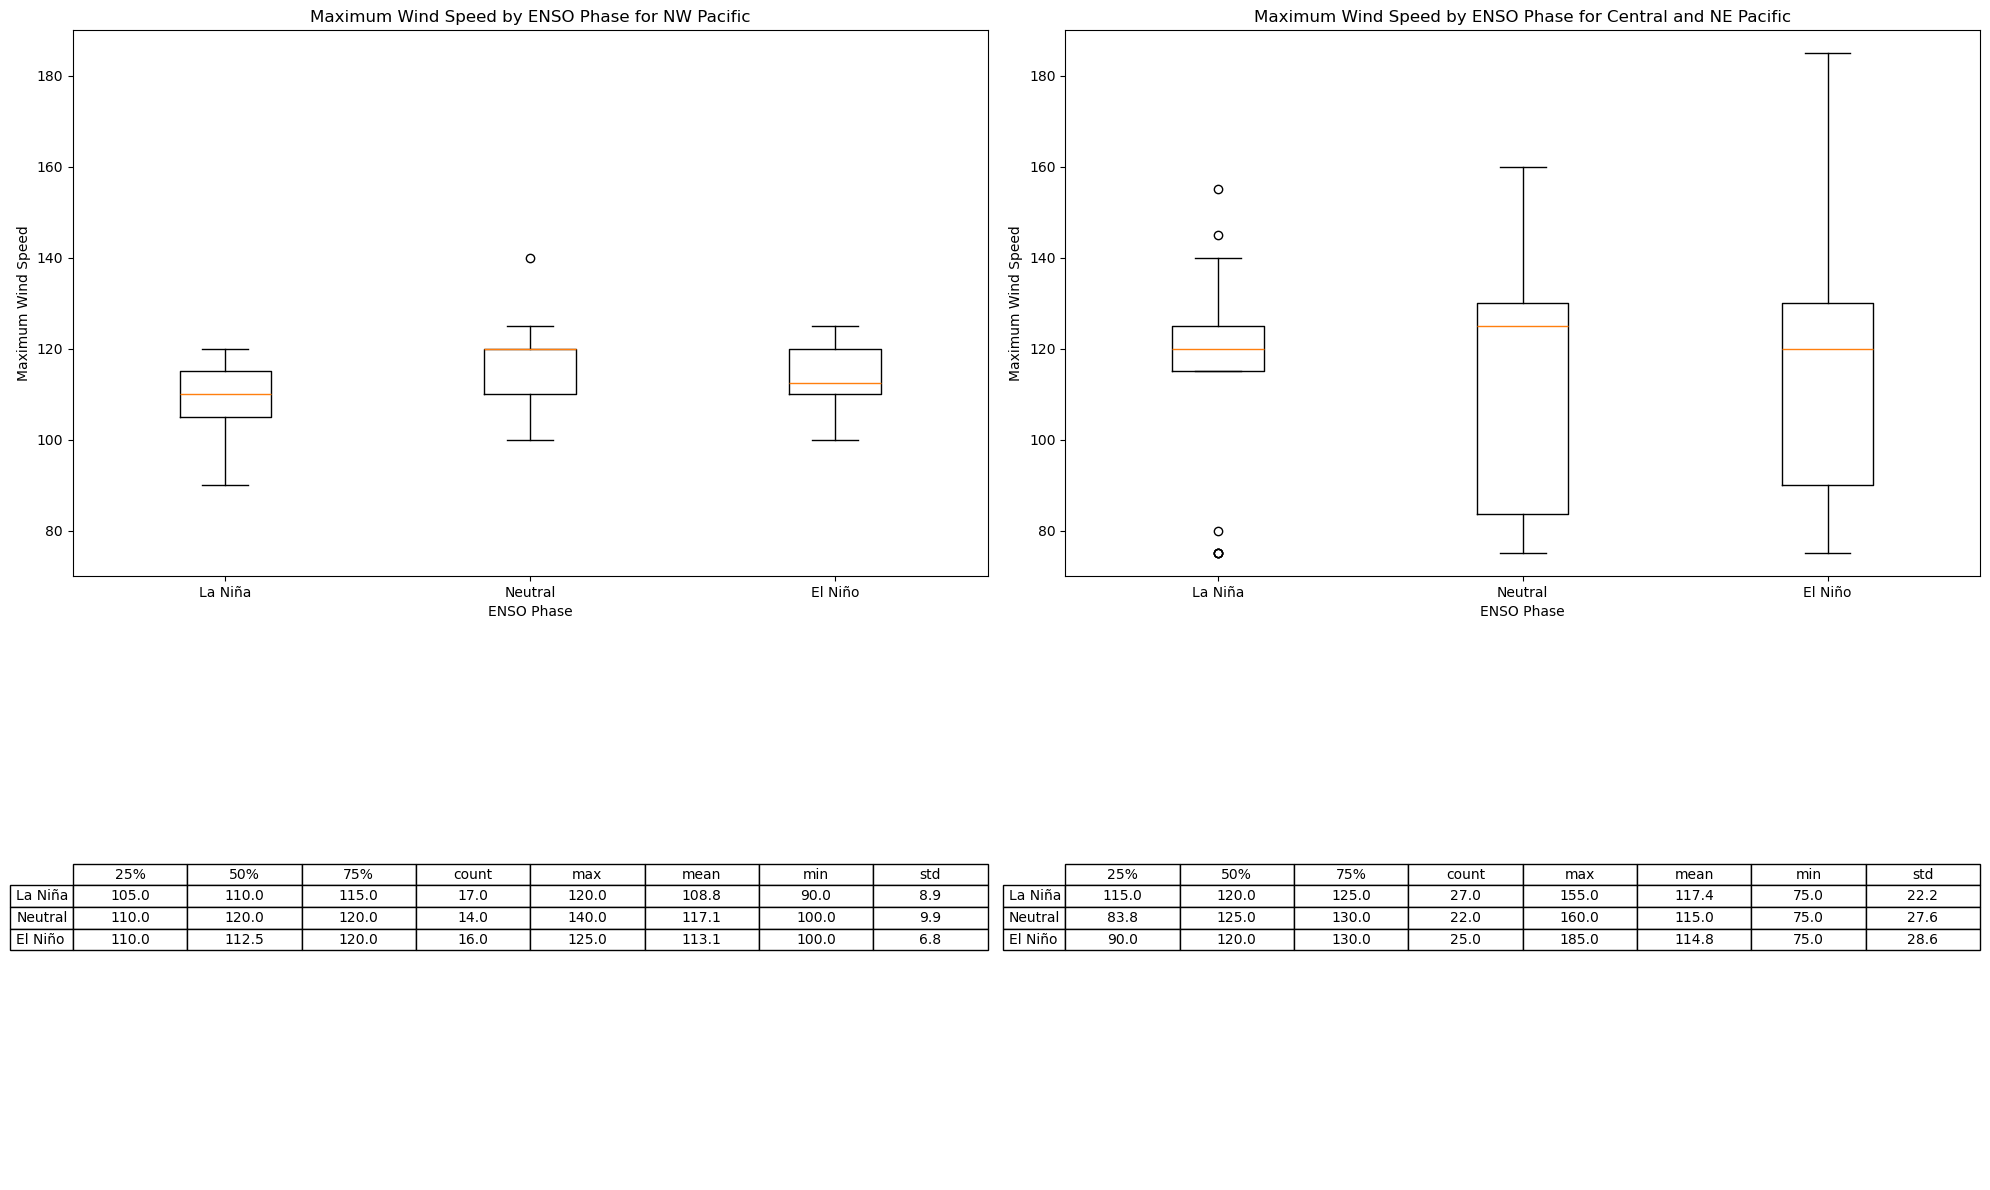

In [21]:
# Boxplot for Maximum Wind Speed
dataset_boxplot = [jma_max_wind, nhc_max_wind]
dataset_table = [jma_max_wind_stats, nhc_max_wind_stats]

plot_boxplot_and_table(dataset_boxplot, dataset_table, 'max_wind_kn', 'Maximum Wind Speed', ylim=(70, 190))

#### Wind Speed Analysis for NW and Central/NE Pacific
1. *Mean Wind Speeds*:
**Neutral Years**: The NW Pacific has the highest mean wind speed during Neutral years (117.14 knots), while the NE and Central Pacific also show strong storms but with a slightly lower mean (115.00 knots). This suggests that during Neutral years, both regions experience relatively high-intensity storms, with the NW Pacific showing slightly stronger storms on average.
**La Niña Years**: The mean wind speed is higher in the NE and Central Pacific (117.41 knots) compared to the NW Pacific (108.82 knots). This suggests that La Niña conditions might be associated with stronger storms in the NE and Central Pacific than in the NW Pacific.
**El Niño Years**: The mean wind speed is slightly lower in the NW Pacific (113.13 knots) compared to the NE and Central Pacific (114.80 knots), but the difference is minimal. This indicates that El Niño influences storm intensities similarly across both regions.

2. *Variability (Standard Deviation)*:
**NE and Central Pacific**: There is significantly more variability in wind speeds during all ENSO phases in the NE and Central Pacific compared to the NW Pacific. The standard deviation is highest during El Niño years (28.59 knots) and lowest during La Niña years (22.25 knots). This suggests that while the mean wind speeds are similar, the NE and Central Pacific region experiences a wider range of storm intensities.
**NW Pacific**: The NW Pacific shows lower variability in wind speeds, especially during El Niño years (6.80 knots), indicating more consistent storm intensities during these phases.

3. *Range of Wind Speeds (Min and Max)*:
**NE and Central Pacific**: The range of wind speeds is much broader, particularly during El Niño years, where the maximum wind speed reaches 185.0 knots. This suggests the presence of exceptionally strong storms during El Niño years in the NE and Central Pacific.
**NW Pacific**: The wind speed range is narrower, with a maximum of 140.0 knots during Neutral years. This indicates that the NW Pacific experiences strong storms, but not as extreme as those in the NE and Central Pacific during the same period.

4. *Percentiles (25%, 50%, 75%)*:
**NE and Central Pacific**: The wider inter quartile ranges (IQR) reflect the greater variability in storm intensities across all ENSO phases. For example, the IQR during El Niño years spans from 90.0 to 130.0 knots, indicating that while some storms are moderate, others are exceptionally strong.
**NW Pacific**: The percentiles are more tightly clustered, especially during El Niño years, where the IQR spans from 110.0 to 120.0 knots. This reflects more consistent storm intensities in the NW Pacific.

**Conclusion**:

**Regional Differences:** The analysis reveals that the NE and Central Pacific experiences more variability in storm intensities across all ENSO phases, with some extremely strong storms, particularly during El Niño years. In contrast, the NW Pacific sees slightly higher mean intensities during Neutral years but generally experiences more consistent and less variable storm intensities.

**ENSO Phase Influence:** Both regions exhibit strong storms during Neutral and La Niña years, but the impact of El Niño appears more pronounced in the NE and Central Pacific, where the range and variability of storm intensities are much greater.

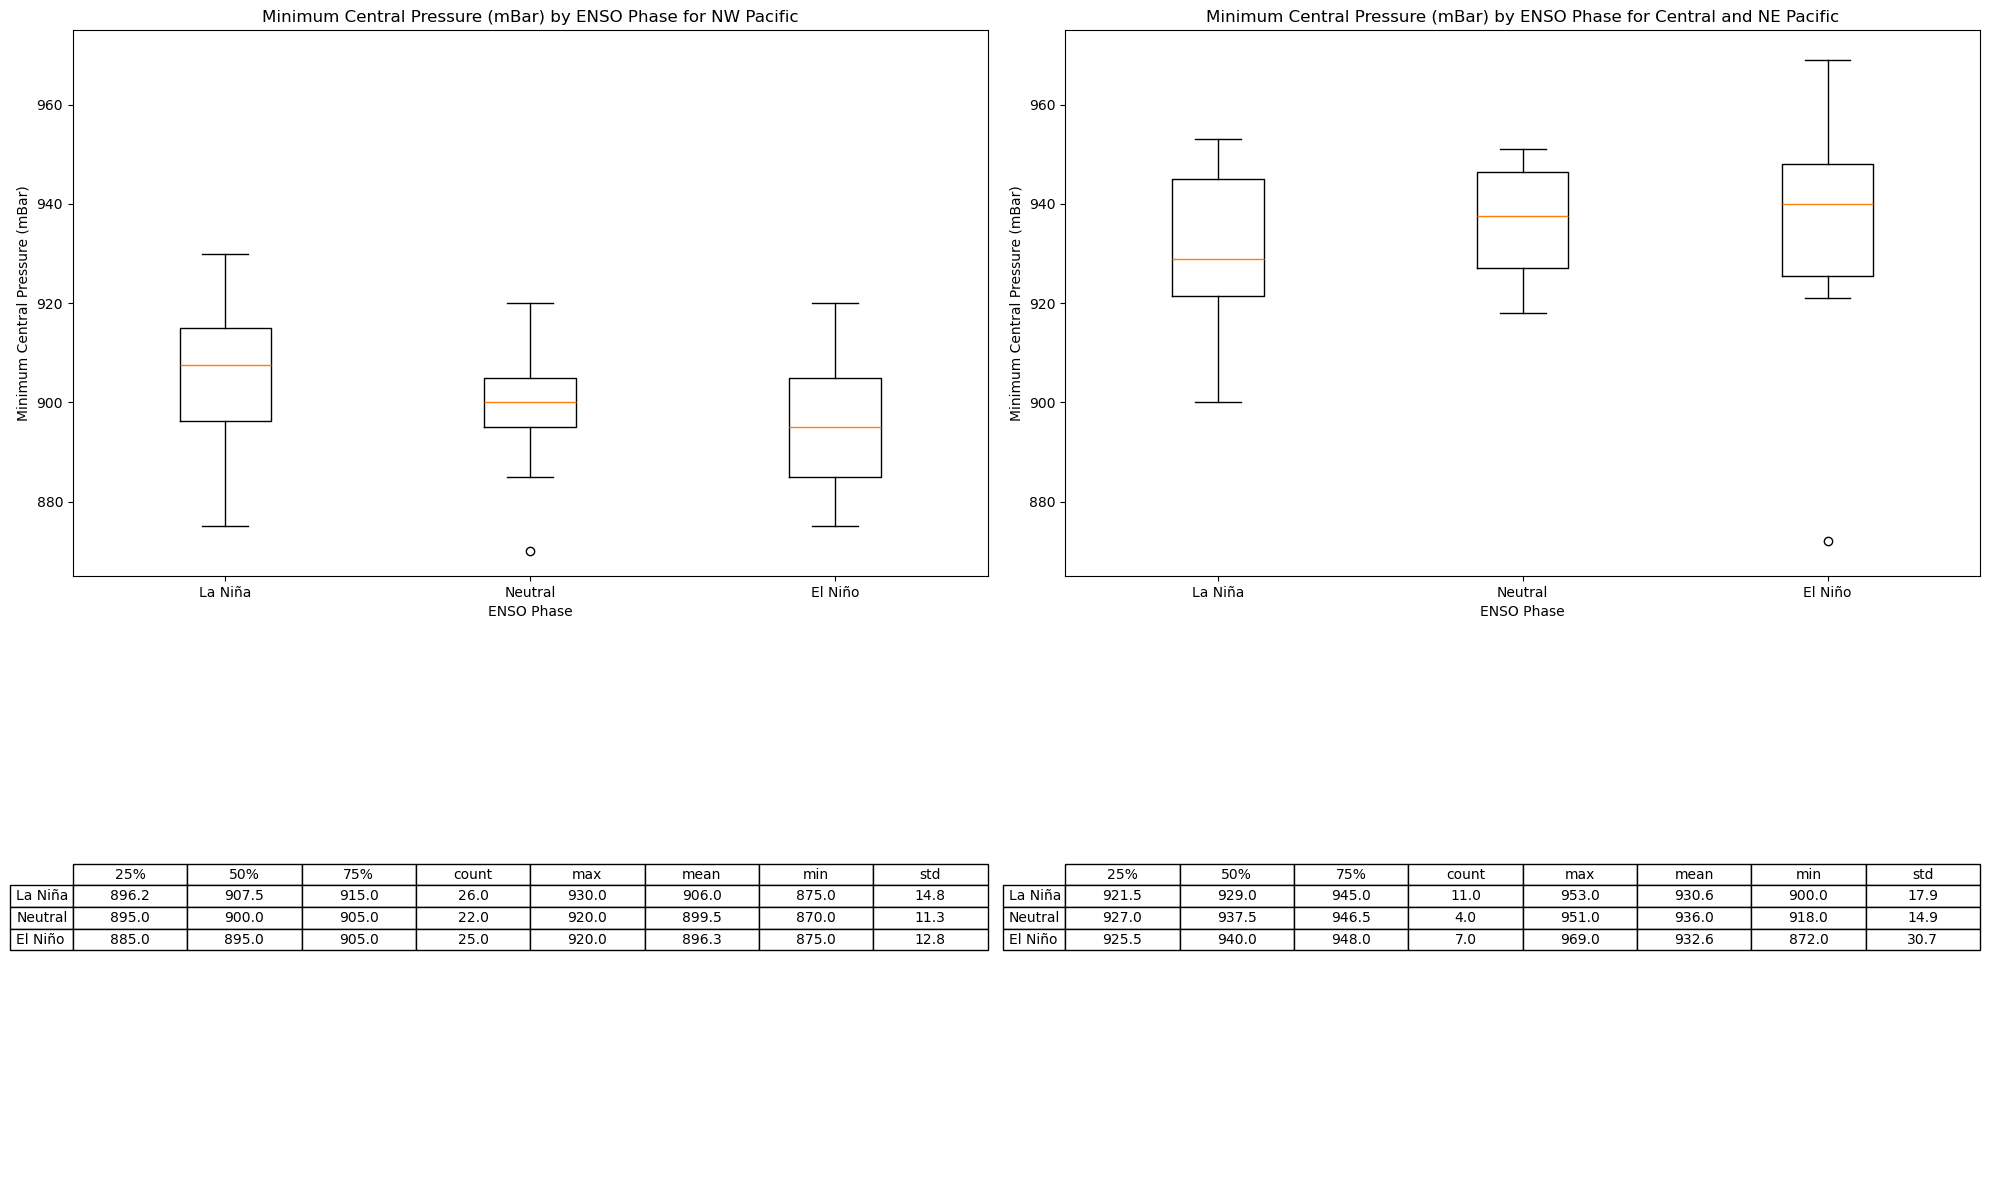

In [22]:
# Boxplot for Minimum Central Pressure
dataset_boxplot = [jma_min_press, nhc_min_press]
dataset_table = [jma_min_press_stats, nhc_min_press_stats]

plot_boxplot_and_table(dataset_boxplot, dataset_table, 'min_pressure_mBar', 'Minimum Central Pressure (mBar)', ylim=(865, 975))

#### Central Pressure Analysis for NW and Central/NE Pacific
1. *Mean Minimum Central Pressure:*
**NW Pacific**:
During all ENSO phases, the mean minimum central pressure is lower (indicating stronger storms) in the NW Pacific compared to the NE and Central Pacific.
The lowest mean pressure is observed during El Niño years (896.28 mbar), suggesting that these years might see the most intense storms in terms of central pressure.
**NE and Central Pacific:**
La Niña: The mean is 930.64 mBar, which is significantly higher than in the NW Pacific, suggesting less intense storms during La Niña years in the NE and Central Pacific compared to NW Pacific, however, La Niña phase has the lowest mean central pressure, indicating potentially strongest storms among the phases.

2. *Variability (Standard Deviation)*:
**NW Pacific**: The standard deviation is relatively consistent across ENSO phases, with the lowest during Neutral years (11.33 mBar) and the highest during La Niña years (14.78 mBar). This indicates that the NW Pacific has relatively stable storm intensities with moderate variability.
**NE and Central Pacific**: The standard deviation is highest during El Niño years (30.74 mBar), suggesting greater variability in storm intensities during these years. This could indicate the presence of both very strong and relatively weak storms during El Niño years.
Lower variability during La Niña and Neutral years suggests more consistent storm intensities, but with generally higher minimum central pressures, indicating less intense storms overall.

4. *Range of Pressures (Min and Max)*:
**NW Pacific**:
The range of minimum central pressures is lower during El Niño years (875.0 to 920.0 mBar) compared to other phases, indicating that storms tend to be more intense during these years.
The highest maximum pressure during La Niña years (930.0 mBar) suggests that some storms could be less intense, though still more intense than those in the NE and Central Pacific.
**NE and Central Pacific**:
The pressure range is broader during El Niño years (872.0 to 969.0 mBar), suggesting that this region experiences both very strong and relatively weak storms during these years.
During Neutral and La Niña years, the minimum pressures are higher (918.0 mBar and 900.0 mBar, respectively), indicating generally weaker storms compared to the NW Pacific.

5. *Percentiles (25%, 50%, 75%)*:
**NW Pacific**:
The interquartile range (IQR) is narrower during Neutral years, with the 50th percentile (median) at 900.0 mbar, indicating that the central 50% of storms are fairly consistent in intensity.
During El Niño years, the 25th percentile is the lowest (885.0 mbar), suggesting that a significant portion of storms during these years are particularly intense.
**NE and Central Pacific**:
The IQR is broader during El Niño years, with a median of 940.0 mbar, reflecting greater variability in storm intensities. The lower 25th percentile (925.5 mbar) still indicates less intense storms compared to the NW Pacific.

**Conclusion**:

**Regional Differences**: The NW Pacific tends to experience more intense tropical depressions across all ENSO phases compared to the NE and Central Pacific. This is reflected in the generally lower mean and median central pressures in the NW Pacific, particularly during El Niño years.

ENSO Influence:
**NW Pacific**: The lowest central pressures (indicating stronger storms) are observed during El Niño years, followed by Neutral years, and the least intense storms during La Niña years.
**NE and Central Pacific**: Storms are generally less intense, with higher variability during El Niño years and more consistent, though weaker, storms during La Niña and Neutral years.
**Implications**: These findings suggest that the NW Pacific is more prone to intense tropical depressions during El Niño years, while the NE and Central Pacific experience a wider range of storm intensities during the same period. This variability in storm intensity across regions and ENSO phases has important implications for forecasting, disaster preparedness, and understanding the broader climatic impacts of ENSO.

### Geospatial Analysis

The goal of geospatial analysis is to examine the spatial distribution and movement of tropical depressions across different ENSO phases in the Pacific Ocean. This analysis helps identify patterns in where and how tropical depressions form and move, depending on the phase of the ENSO cycle.

In [23]:
enso_phase_dt = enso_phase.copy()
enso_phase_dt.index = pd.to_datetime(enso_phase.index.astype(str))

merged = pd.merge(jma, enso_phase_dt, left_on=jma.index.year, right_on=enso_phase_dt.index.year, how='left')
merged = merged.set_index(jma.index)
jma_enso = merged.drop(columns='key_0')

merged = pd.merge(nhc, enso_phase_dt, left_on=nhc.index.year, right_on=enso_phase_dt.index.year, how='left')
merged = merged.set_index(nhc.index)
nhc_enso = merged.drop(columns='key_0')

gdf = pd.read_csv('data/csv_ready/gdf_pacific.csv')

In [150]:
def plot_td_density():
    """ 
    Plots the density of Tropical Depressions (TDs) for different phases of ENSO (El Niño, La Niña, Neutral) 
    across the North Pacific Ocean. The function creates density plots using kernel density estimation (KDE) 
    for each phase and visualizes them on a subplot.
    """
    cmaps = get_cmaps()
    phases = get_phase_names()

    datasets = [jma_enso, nhc_enso]
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20 * 3, 8))

    for idx, i in enumerate(range(-1, 2, 1)):
        for df in datasets:
            subset = df[df.enso == i]  
            sns.kdeplot(x=subset['lon'], y=subset['lat'], fill=True, cmap=cmaps[i], bw_adjust=0.8, ax=axs[idx])

        axs[idx].scatter(gdf.lon, gdf.lat, s=0.5, color='black')
        
        x_tick = np.arange(100, 300, 10)
        x_label = [f'{x}°E' if x <= 180 else f'{360 - x}°W' for x in x_tick]
        y_tick = np.arange(-20, 70, 10)
        y_label = [f'{np.abs(x)}°S' if x < 0 else f'{np.abs(x)}°N' for x in y_tick]
        axs[idx].set_xticks(ticks=x_tick)
        axs[idx].set_xticklabels(labels=x_label)
        axs[idx].set_yticks(ticks=y_tick)
        axs[idx].set_yticklabels(labels=y_label)
        
        axs[idx].set_title(f'Density of Tropical Depressions for {phases[i]} phase')
        axs[idx].set_xlabel('Longitude')
        axs[idx].set_ylabel('Latitude')
        
    plt.tight_layout()
    plt.show()
    

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great-circle distance between two points on the Earth 
    specified in decimal degrees using the Haversine formula.
    
    Parameters:
        lon1, lat1: Longitude and latitude of the first point.
        lon2, lat2: Longitude and latitude of the second point.
    
    Returns:
        Distance between the two points in kilometers.
    """
    # Convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    # Radius of Earth in kilometers (mean radius)
    R = 6371.0088
    return R * c

def haversine_(lon1, lat1, lon2, lat2):
    # Convert all points to radians
    first_points_rad = np.radians(np.vstack([lon1, lat1]).T)  # (N, 2) array where N is the number of points
    second_point_rad = np.radians([lon2, lat2])  # Single point in radians

    # Compute Haversine distance between each point and the single grid point
    result = haversine_distances(first_points_rad, [second_point_rad])  # (N, 1) array of distances

    # Return distances in kilometers
    return result.flatten() * 6371.0088  # Earth's radius in kilometers

def compute_kde_values(df, phase, method, gridsize=100, bandwidth=0.1):

    # Subset data for the specific ENSO phase
    subset = df[df.enso == phase]
    
    # Extract longitude and latitude values
    lon_vals = subset['lon'].values
    lat_vals = subset['lat'].values
    
    # Define grid boundaries in degrees
    lon_min, lon_max = 100, 300
    lat_min, lat_max = -20, 70
    lon_grid, lat_grid = np.linspace(lon_min, lon_max, gridsize), np.linspace(lat_min, lat_max, gridsize)
    lon_grid, lat_grid = np.meshgrid(lon_grid, lat_grid)
    
    if method == 'haversine':
        # Initialize KDE grid
        kde_values = np.zeros(lon_grid.shape)
        
        # Compute KDE using Haversine distance for each grid point
        for i in range(gridsize):
            for j in range(gridsize):
                # Calculate the distance from each data point to the grid point
                distances = haversine_(lon_vals, lat_vals, lon_grid[i, j], lat_grid[i, j])         
                # Apply Gaussian kernel to distances and sum
                kde_values[i, j] = np.sum(np.exp(-0.5 * (distances / bandwidth)**2))
        
        # Normalize KDE values
        kde_values /= (bandwidth * np.sqrt(2 * np.pi)) * len(lon_vals)

    elif method == 'euclidean':
        kde = gaussian_kde(np.vstack([subset['lon'], subset['lat']]))
        kde_values = kde(np.vstack([lon_grid.ravel(), lat_grid.ravel()])).reshape(gridsize, gridsize)
    
    return lon_grid, lat_grid, kde_values
    
def plot_td_density_difference(method):
    """ 
    Plots the density differences of Tropical Depressions (TDs) for different ENSO phases 
    (El Niño, La Niña, Neutral) across the North Pacific Ocean. It computes the differences 
    between KDE values for each phase and creates visual comparisons using heatmaps. 
    The function shows the results for both NW Pacific and NE/Central Pacific regions.
    """
    kde_values_jma = {phase: compute_kde_values(jma_enso, phase, method)[2] for phase in range(-1, 2)}
    kde_values_nhc = {phase: compute_kde_values(nhc_enso, phase, method)[2] for phase in range(-1, 2)}

    # Subtract KDE values to create difference maps for each region
    diff_maps_jma = {
        'El Niño - La Niña (NW Pacific)': kde_values_jma[1] - kde_values_jma[-1],
        'Neutral - La Niña (NW Pacific)': kde_values_jma[0] - kde_values_jma[-1],
        'Neutral - El Niño (NW Pacific)': kde_values_jma[0] - kde_values_jma[1]
    }
    
    diff_maps_nhc = {
        'El Niño - La Niña (NE/Central Pacific)': kde_values_nhc[1] - kde_values_nhc[-1],
        'Neutral - La Niña (NE/Central Pacific)': kde_values_nhc[0] - kde_values_nhc[-1],
        'Neutral - El Niño (NE/Central Pacific)': kde_values_nhc[0] - kde_values_nhc[1]
    }

    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20, 12))
    
    for i, diff_dt in enumerate([diff_maps_jma, diff_maps_nhc]):
        for idx, (title, diff_map) in enumerate(diff_dt.items()):
            im = axs[i, idx].imshow(diff_map, extent=[100, 300, -20, 70], origin='lower', cmap='coolwarm')
            axs[i, idx].set_title(title)
            axs[i, idx].scatter(gdf.lon, gdf.lat, s=0.5, color='black')
            
            x_tick = np.arange(100, 300, 25)
            x_label = [f'{x}°E' if x <= 180 else f'{360 - x}°W' for x in x_tick]
            y_tick = np.arange(-20, 70, 20)
            y_label = [f'{np.abs(x)}°S' if x < 0 else f'{np.abs(x)}°N' for x in y_tick]
            axs[i, idx].set_xticks(ticks=x_tick)
            axs[i, idx].set_xticklabels(labels=x_label)
            axs[i, idx].set_yticks(ticks=y_tick)
            axs[i, idx].set_yticklabels(labels=y_label)
            
            axs[i, idx].set_xlabel('Longitude')
            axs[i, idx].set_ylabel('Latitude')
    
    plt.tight_layout()
    plt.show()

In [25]:
# plot_td_density()

Density plots help identify areas where tropical depressions are more likely to form or intensify. These areas of higher density represent regions that consistently experience more tropical activity. They allow for direct comparison between phases. It is clear how the spatial distribution of TDs shifts under different climatic conditions.

The color intensity in the density plot corresponds to the density of tropical depressions in that area. **Darker color** indicate regions where TDs are more concentrated. These areas are "hotspots" where tropical depressions are more likely to form or pass through during that particular phase.
**Lighter color** represent areas with lower density, indicating regions where TDs are less frequent.

The **contour lines** represent areas of equal density. The closer the contour lines are, the steeper the change in density, indicating a rapid increase or decrease in the number of TDs in that area.

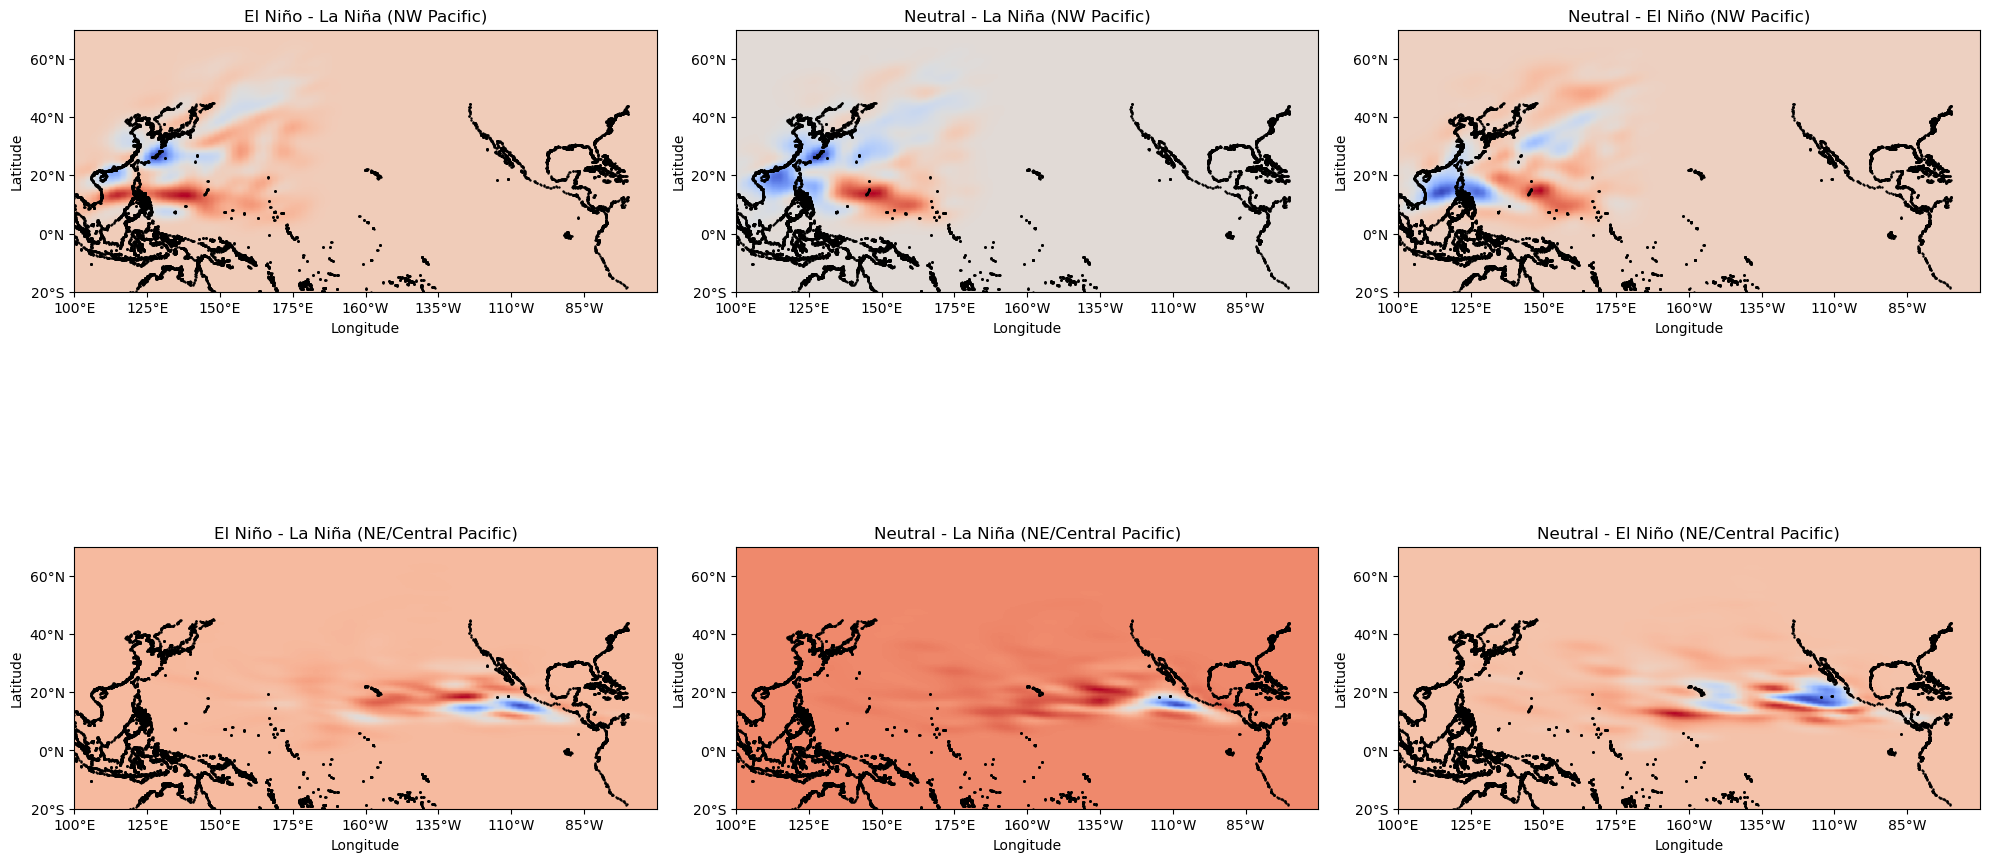

In [28]:
plot_td_density_difference(method='euclidean')

The plot above represent the difference in the spatial density of tropical depressions (TDs) between the different ENSO phases. These difference provide a visual representation of how the spatial distribution of tropical depressions shifts between different ENSO phases, highlighting regions where the density increases or decreases.

**Red Areas:** Indicate regions where the density of tropical depressions is higher during the first phase of comparison (e.g., El Niño) compared to the second phase (e.g., La Niña). For instance, in the plot labeled "El Niño - La Niña (NW Pacific)", red areas show where tropical depressions are more common during El Niño years than La Niña years.

**Blue Areas:** Indicate regions where the density is lower during the first phase compared to the second. For example, blue areas in the "El Niño - La Niña (NW Pacific)" plot show where tropical depressions are more frequent during La Niña years than El Niño years.

**White/Neutral Areas:** Regions with little to no color (white or light gray) suggest that there is no significant difference in the density of tropical depressions between the compared phases.

**Dominance Interpretation:** The overall color gives a quick visual cue as to which ENSO phase is more influential in driving tropical depression activity in the region.

#### Density Maps for the NW Pacific:

**El Niño Period:**

*Observation:* The density difference plot shows higher density of tropical depressions (TDs) to the east and west of the Philippines during El Niño compared to La Niña.

*Interpretation:* This suggests that during El Niño years, tropical depressions tend to remain more concentrated in the western Pacific, particularly around the Philippines, rather than quickly turning northeast and transitioning into extratropical systems. The tendency for TDs to linger in this region could indicate that the steering flow patterns during El Niño are less conducive to an early northeastward turn, potentially leading to prolonged impacts in the western Pacific, including increased storm activity and potential landfall in the Philippines and nearby regions.

**La Niña Period:**

*Observation:* The density difference plot indicates a higher concentration of TDs near SE Japan during La Niña compared to El Niño.

*Interpretation:* This pattern suggests that during La Niña years, tropical depressions are more likely to take a northeasterly track, moving towards Japan and becoming extratropical systems. The shift in TD concentration toward Japan implies that the atmospheric conditions during La Niña favor an earlier and more consistent northeastward movement of storms, increasing the likelihood of storm impacts in Japan and surrounding areas.

**Neutral Phase:**

*Observation:* The main difference in TD concentration during the Neutral phase is observed around the Marshall Islands.

*Interpretation:* This indicates that during Neutral years, the spatial distribution of TDs shifts somewhat, with a notable increase in activity around the Marshall Islands. This could reflect a more balanced atmospheric circulation pattern during Neutral phases, where the conditions neither strongly favor the patterns observed during El Niño nor La Niña. The increased activity around the Marshall Islands might suggest a broader range of storm tracks, with some TDs originating or intensifying in this region before potentially moving towards either the western Pacific or northeastward.

#### Density Maps for the Central and NE Pacific:

**El Niño Period:**

*Observation:* The density difference plot shows a higher density of tropical depressions (TDs) in the region around 130°W, extending westward toward Hawaii.

*Interpretation:* This suggests that during El Niño years, tropical depressions are more likely to follow a westward track, increasing the likelihood of impacting the Hawaiian Islands compared to La Niña years. The altered atmospheric and oceanic conditions during El Niño may lead to a more westward steering flow, which pushes TDs towards the central Pacific, making landfall on Hawaii more probable.


**La Niña Period:**

*Observation:* The density difference plot indicates a higher concentration of TDs near the coast of Mexico.

*Interpretation:* This pattern suggests that during La Niña years, tropical depressions are more likely to develop and intensify near Mexico, with a greater chance of making landfall there compared to El Niño years. La Niña conditions typically favor stronger easterly trade winds and a more conducive environment for tropical cyclone formation near the eastern Pacific, leading to more frequent landfalls in Mexico.

**Neutral Phase:**

*Observation:* The Neutral phase, when compared to both El Niño and La Niña, shows that tropical depression activity tends to be more evenly distributed across the Pacific, rather than being concentrated in specific regions. However, there are still distinct areas where El Niño and La Niña exert stronger influences.

*Interpretation compared to El Niño:* This suggests that during Neutral years, there is a higher density of tropical depressions (TDs) in the broader Pacific region compared to El Niño years. However, during El Niño, the density of TDs is particularly concentrated southeast of California and around Hawaii. The strong blue southeast of California indicates that during El Niño, more tropical depressions tend to form or pass through this area, while the light blue around Hawaii suggests a similar, but less pronounced, tendency for TDs to impact the region during El Niño. In contrast, during Neutral years, the overall activity is more spread out across the Pacific, but with less concentration in these specific regions.

*Interpretation  compared to La Niña:* Neutral years again show more evenly spread activity, while La Niña creates a strong concentration of TDs off the coast of Mexico, indicating a marked difference in behavior between these phases.

In [186]:
# Define the Haversine function to apply on arrays
def haversine_array(latlon1, latlon2):
    """
    Compute the Haversine distance between two sets of points.
    
    Parameters:
        latlon1 (array-like): An array of (latitude, longitude) pairs.
        latlon2 (array-like): Another array of (latitude, longitude) pairs.
        
    Returns:
        distances (ndarray): An array of distances between each pair of points.
    """
    # Radius of Earth in kilometers
    R = 6371
    
    # Convert to radians
    lat1, lon1 = np.radians(latlon1[:, 0]), np.radians(latlon1[:, 1])
    lat2, lon2 = np.radians(latlon2[:, 0]), np.radians(latlon2[:, 1])

    # Reshape to allow broadcasting of arrays for pairwise distance calculations
    lat1 = lat1[:, np.newaxis]  # Shape (N, 1)
    lon1 = lon1[:, np.newaxis]  # Shape (N, 1)
    
    # Differences in coordinates
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    # Haversine formula components
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    # Distance in kilometers
    distances = R * c
    return distances

def run_dbscan(df, method, eps, min_samples):
    """ 
    Runs the DBSCAN clustering algorithm on a dataset of geographical coordinates (longitude and latitude). 
    It returns the clusters formed and the corresponding labels for each point.
    
    Parameters:
        df (DataFrame): The dataset containing 'lon' and 'lat' columns.
        eps (float): The maximum distance between two samples for them to be considered as neighbors (default: 1.0).
        min_samples (int): The minimum number of samples required to form a cluster (default: 5).
    
    Returns:
        clusters (list of arrays): A list of clusters, where each cluster contains the coordinates of points.
        labels (ndarray): An array of labels for each point (-1 for noise, integers for cluster membership).
    """
    if method == 'haversine':
        # Convert lat/lon from degrees to radians
        coords = np.radians(df[['lon', 'lat']].values)
        # The eps parameter in DBSCAN must be in radians when using Haversine distance.
        # To convert eps from kilometers to radians, divide by Earth's radius (6371.0088 km).
        eps_radians = eps / 6371.0088
        # Run DBSCAN with Haversine metric
        db = DBSCAN(eps=eps_radians, min_samples=min_samples, metric='haversine').fit(coords)
        labels = db.labels_
        unique_labels = set(labels)
    elif method == 'euclidean':
        # Extract clusters, exclude noise (-1)
        coords = df[['lon', 'lat']].values
        db = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean').fit(coords)
        labels = db.labels_
        unique_labels = set(labels)
        
    clusters = [coords[labels == label] for label in unique_labels if label != -1]  # Exclude noise (-1)
    return clusters, labels

def compute_cluster_metrics(clusters):
    """ 
    Computes metrics for a set of clusters, including the number of clusters, average cluster size, 
    and the centroids of the clusters.
    
    Parameters:
        clusters (list of arrays): A list of clusters, where each cluster contains the coordinates of points.
    
    Returns:
        num_clusters (int): The number of clusters.
        average_size (float): The average size (number of points) of the clusters.
        centroids (list of arrays): A list of centroid coordinates for each cluster.
    """
    num_clusters = len(clusters)
    cluster_sizes = [len(cluster) for cluster in clusters]
    average_size = np.mean(cluster_sizes)
    centroids = [np.mean(cluster, axis=0) for cluster in clusters]
    return num_clusters, average_size, centroids


def compare_clusters(centroids1, centroids2, method):
    """ 
    Compares two sets of cluster centroids by computing the mean, median, minimum, and maximum Haversine distances 
    between centroids in the two sets.
    
    Parameters:
        centroids1 (list of arrays): The centroids of the first set of clusters.
        centroids2 (list of arrays): The centroids of the second set of clusters.
    
    Returns:
        mean_distance (float): The mean Haversine distance between centroids in the two sets.
        median_distance (float): The median Haversine distance between centroids in the two sets.
        min_distance (float): The minimum Haversine distance between centroids in the two sets.
        max_distance (float): The maximum Haversine distance between centroids in the two sets.
    """
    if method == 'haversine':
        # Convert the centroids to numpy arrays
        latlon1 = np.array(centroids1)
        latlon2 = np.array(centroids2)
        
        # Compute all pairwise Haversine distances
        distances = haversine_array(latlon1, latlon2).flatten()  # Flatten to get a 1D array
    elif method == 'euclidean':
        distances = []
        for c1 in centroids1:
            for c2 in centroids2:
                distances.append(euclidean(c1, c2))
   
    return np.mean(distances), np.median(distances), np.min(distances), np.max(distances)


def compare_enso_phases_dbscan(df, method, eps=1.0, min_samples=5):
    """ 
    Runs DBSCAN clustering on the dataset for different ENSO phases (La Niña, El Niño, Neutral), 
    computes cluster metrics for each phase, and compares the clusters between phases.
    
    Parameters:
        df (DataFrame): The dataset containing 'lon', 'lat', and 'enso' columns.
        eps (float): The maximum distance between two samples for them to be considered as neighbors (default: 1.0).
        min_samples (int): The minimum number of samples required to form a cluster (default: 5).
    
    Returns:
        results (dict): A dictionary containing the number of clusters, average size, and centroids for each ENSO phase.
        comparisons (dict): A dictionary containing the mean, median, minimum, and maximum distances between centroids 
                            of clusters for different ENSO phases.
    """
    phases = {
        'La Niña': df[df.enso == -1],
        'El Niño': df[df.enso == 1],
        'Neutral': df[df.enso == 0]
    }

    results = {}

    # Compute DBSCAN metrics for each phase
    for phase, df in phases.items():
        clusters, _ = run_dbscan(df, method, eps=eps, min_samples=min_samples)
        metrics = compute_cluster_metrics(clusters)
        results[phase] = metrics

    # Compare clusters between phases
    comparisons = {}
    phases_list = list(phases.keys())
    for i in range(len(phases_list)):
        for j in range(i + 1, len(phases_list)):
            phase1, phase2 = phases_list[i], phases_list[j]
            mean_dist, median_dist, min_dist, max_dist = compare_clusters(results[phase1][2], results[phase2][2], method)
            comparisons[f'{phase1} vs {phase2}'] = {
                'Mean Distance': mean_dist,
                'Median Distance': median_dist,
                'Min Distance': min_dist,
                'Max Distance': max_dist
            }

    return results, comparisons

In [156]:
def plot_clusters(results, region):
    """ 
    Plots the number of clusters and the average cluster size for each ENSO phase in a specified region. 
    The number of clusters is displayed as a bar chart, and the average cluster size is shown as a scatter plot.
    
    Parameters:
        results (dict): A dictionary containing the number of clusters and average cluster size for each ENSO phase.
        region (str): The name of the region (e.g., "NW" or "NE/Central Pacific") where the analysis is conducted.
    """
    
    phases = list(results.keys())
    num_clusters = [results[phase][0] for phase in phases]
    avg_cluster_sizes = [results[phase][1] for phase in phases]

    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Bar chart for the number of clusters
    bars = ax1.bar(phases, num_clusters, color='skyblue', alpha=0.7, label='Number of Clusters')
    ax1.set_xlabel('ENSO Phases')
    ax1.set_ylabel('Number of Clusters', color='skyblue')
    ax1.tick_params(axis='y', labelcolor='skyblue')
    add_value_labels(ax1, bars)
    
    # Line chart for the average cluster size
    ax2 = ax1.twinx()
    ax2.scatter(phases, avg_cluster_sizes, color='orange', marker='o', linestyle='-', label='Average Cluster Size')
    ax2.set_ylabel('Average Cluster Size', color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')

    for i, value in enumerate(avg_cluster_sizes):
        ax2.annotate(f'{value:.2f}', 
                    xy=(phases[i], value), 
                    xytext=(8, 0), 
                    textcoords="offset points",
                    ha='left', va='center', 
                    color='orange')
    
    # Title and layout
    fig.suptitle(f'Number of Clusters and Average Cluster Size by ENSO Phase in {region} Pacific')
    fig.tight_layout()
    plt.show()

def plot_centroid_distance(comparisons, region):
    """ 
    Plots the centroid distance comparison between different ENSO phases. The distances (minimum, mean, 
    median, and maximum) between cluster centroids are visualized for each phase comparison.
    
    Parameters:
        comparisons (dict): A dictionary containing the centroid distances (min, mean, median, max) between ENSO phases.
        region (str): The name of the region (e.g., "NW" or "NE/Central Pacific") where the analysis is conducted.
    """
    
    labels = ['Min Distance', 'Mean Distance', 'Median Distance', 'Max Distance']
    
    # Create a subplot for each phase comparison
    fig, axs = plt.subplots(nrows=1, ncols=len(comparisons), figsize=(18, 6))
    
    for idx, (comparison, metrics) in enumerate(comparisons.items()):
        distances = [metrics['Min Distance'], metrics['Mean Distance'], 
                     metrics['Median Distance'], metrics['Max Distance']]
        
        bars = axs[idx].bar(labels, distances, color=['blue', 'green', 'red', 'orange'])
        axs[idx].set_title(f'Centroid Distance: {comparison}')
        axs[idx].set_ylabel('Distance (Degrees)')
        axs[idx].set_ylim(0, max(distances) * 1.2)
        add_value_labels(axs[idx], bars)
    
    fig.suptitle(f'Centroid Distance Comparisons Between ENSO Phases in {region} Pacific')
    plt.tight_layout()
    plt.show()

def plot_centroid_model(results, comparisons, region):
    """ 
    Combines the cluster metrics and centroid distance comparison into one plot. It first plots the 
    number of clusters and average cluster size for each ENSO phase, and then plots the centroid distance 
    comparisons between different ENSO phases.
    
    Parameters:
        results (dict): A dictionary containing the number of clusters and average cluster size for each ENSO phase.
        comparisons (dict): A dictionary containing the centroid distances (min, mean, median, max) between ENSO phases.
        region (str): The name of the region (e.g., "NW" or "NE/Central Pacific") where the analysis is conducted.
    """
    
    plot_clusters(results, region)
    plot_centroid_distance(comparisons, region)

In [157]:
def print_enso_comparison(results, comparisons):
    # Only for testing purposes
    # Print cluster numbers and average sizes
    for phase, metrics in results.items():
        print(f"Number of {phase} Clusters: {metrics[0]}")
        print(f"Average {phase} Cluster Size: {metrics[1]:.2f}")
        print()

    # Print centroid distance comparisons
    print("Centroid Distance Comparisons:")
    for comparison, metrics in comparisons.items():
        print(f"{comparison}:")
        print(f"  Mean Distance: {metrics['Mean Distance']:.2f}")
        print(f"  Median Distance: {metrics['Median Distance']:.2f}")
        print(f"  Min Distance: {metrics['Min Distance']:.2f}")
        print(f"  Max Distance: {metrics['Max Distance']:.2f}")
        print()

In [ ]:
results, comparisons = compare_enso_phases_dbscan(jma_enso, method='euclidean')
plot_centroid_model(results, comparisons, 'NW')
print_enso_comparison(results, comparisons)

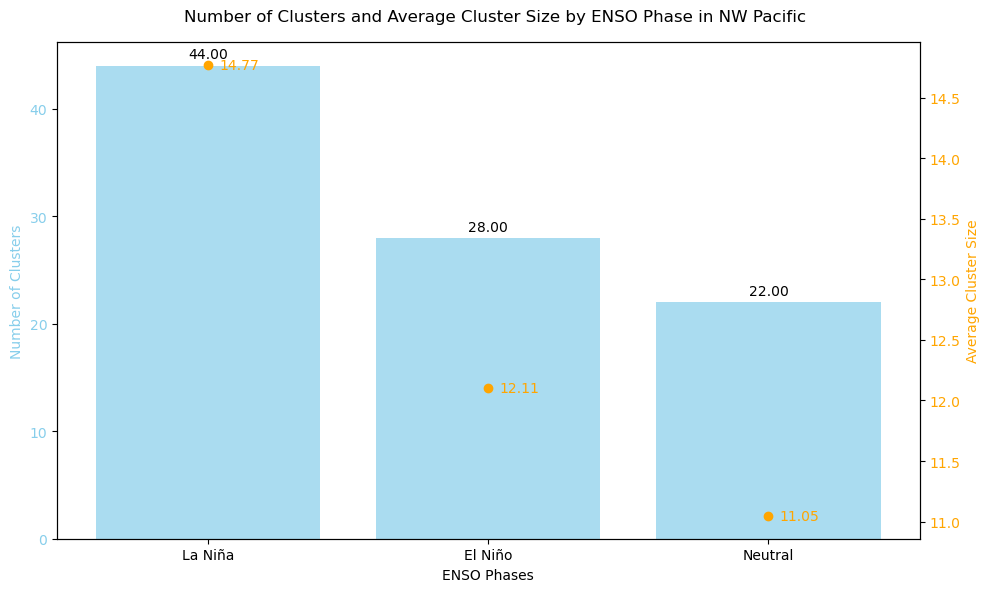

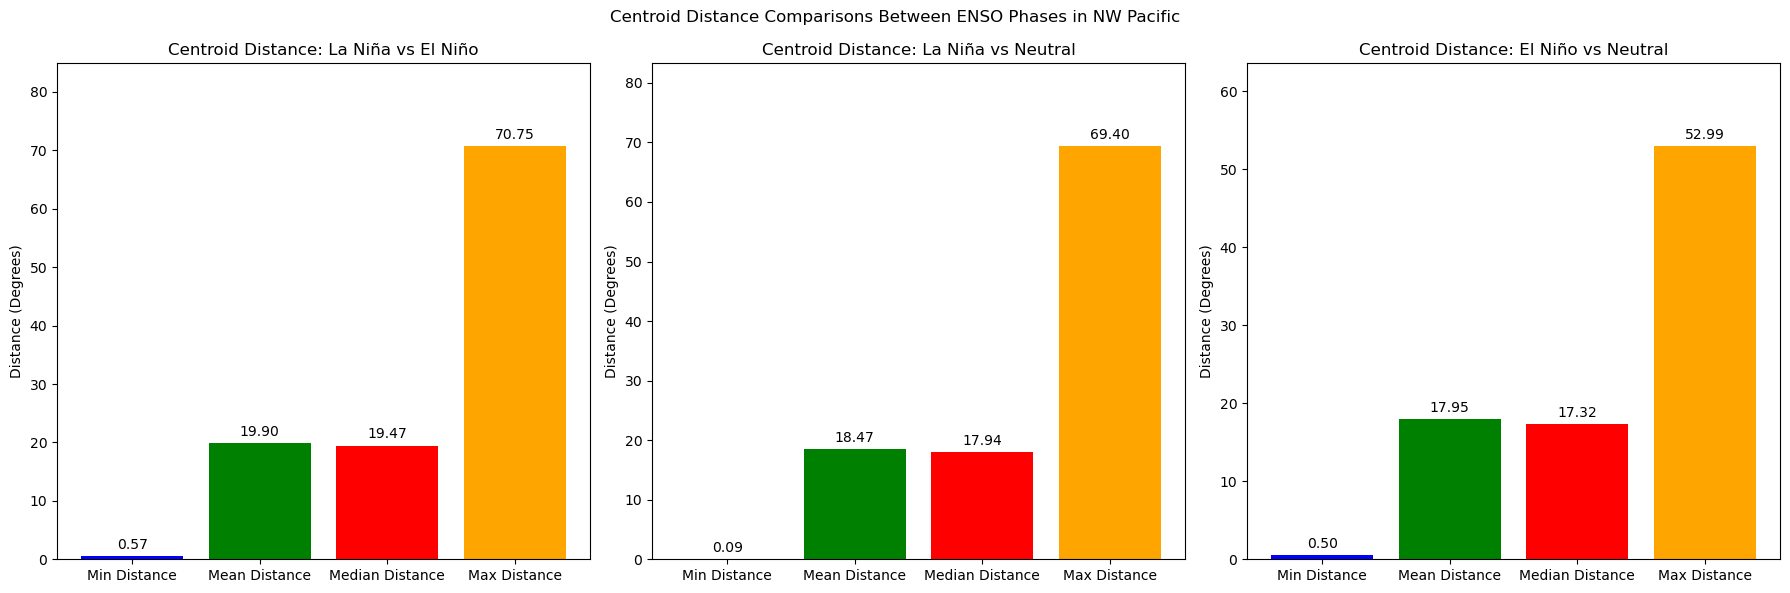

Number of La Niña Clusters: 44
Average La Niña Cluster Size: 14.77

Number of El Niño Clusters: 28
Average El Niño Cluster Size: 12.11

Number of Neutral Clusters: 22
Average Neutral Cluster Size: 11.05

Centroid Distance Comparisons:
La Niña vs El Niño:
  Mean Distance: 19.90
  Median Distance: 19.47
  Min Distance: 0.57
  Max Distance: 70.75

La Niña vs Neutral:
  Mean Distance: 18.47
  Median Distance: 17.94
  Min Distance: 0.09
  Max Distance: 69.40

El Niño vs Neutral:
  Mean Distance: 17.95
  Median Distance: 17.32
  Min Distance: 0.50
  Max Distance: 52.99



In [185]:
results, comparisons = compare_enso_phases_dbscan(jma_enso, method='haversine', eps=15, min_samples=10)
plot_centroid_model(results, comparisons, 'NW')
print_enso_comparison(results, comparisons)

#### Cluster Analysis for NW Pacific

**Interpretation on number of clusters:**

The El Niño phase has the highest number of clusters (36), indicating a more fragmented distribution of tropical depressions (TDs) across the NW Pacific during El Niño years. This fragmentation suggests that TDs are spread over a wider area, forming more distinct clusters.
The La Niña phase has the fewest clusters (18), suggesting that TDs tend to be more concentrated in fewer areas, likely due to stronger and more consistent steering currents or favorable conditions in specific regions.
The Neutral phase falls in between, with 28 clusters, indicating a distribution that is less concentrated than La Niña but not as widespread as El Niño.

**Interpretation of average cluster size:**

The La Niña phase has the largest average cluster size (1299.33), suggesting that when clusters do form during La Niña, they tend to be larger and possibly more intense. This could be due to more favorable and concentrated conditions for TD development in certain regions.
The El Niño phase has the smallest average cluster size (589.81), which aligns with the higher number of clusters. This suggests that while there are more clusters, they are generally smaller and less concentrated, possibly due to more variable conditions across the region.
The Neutral phase has a moderate average cluster size (838.07), indicating a balance between the concentration seen in La Niña and the fragmentation seen in El Niño.

#### Centroid Distance Comparisons for NW Pacific

**La Niña vs El Niño:**

The centroid distances between La Niña and El Niño clusters show a moderate mean (31.03) and median (31.96) distance, indicating that while there are some differences in where TDs tend to form during these phases, there is also significant overlap.
The small minimum distance (0.38) suggests that in some cases, TDs can form in very similar locations during both phases, while the maximum distance (62.24) indicates that TDs can also form in significantly different locations depending on the phase.

**La Niña vs Neutral:**

The centroid distances between La Niña and Neutral phases are slightly larger than between La Niña and El Niño, with a mean of 34.84 and a median of 36.31. This suggests that the spatial distribution of TDs during Neutral phases is somewhat different from La Niña, with TDs likely forming in more varied locations.
The maximum distance (92.36) is quite large, indicating that there can be substantial differences in where TDs form between these two phases, possibly reflecting different steering currents or atmospheric conditions.

**El Niño vs Neutral:**

The centroid distances between El Niño and Neutral phases are similar to those between La Niña and Neutral phases, with a mean of 35.03 and a median of 34.89. This suggests that the distribution of TDs during Neutral phases has significant overlap with El Niño, but also shows substantial differences in certain areas.
The maximum distance (90.99) indicates that in some cases, TDs can form in very different regions during these two phases, further emphasizing the variability in TD formation locations during Neutral years compared to El Niño.

**Overall Summary:**

*La Niña Phase:* TDs are more concentrated, forming fewer but larger clusters. The overlap with El Niño and Neutral phases is moderate, but there are significant areas where TDs form in distinct locations during La Niña compared to the other phases.

*El Niño Phase:* TDs are more widely dispersed, forming many smaller clusters. This phase shows more variability in where TDs form, with some overlap with both La Niña and Neutral phases, but also significant differences in certain areas.

*Neutral Phase:* The distribution of TDs during Neutral years is intermediate between La Niña and El Niño, showing both some concentration and some dispersion. The centroid distances indicate that while there is overlap with both La Niña and El Niño, there are also distinct regions where TDs form differently during Neutral years.

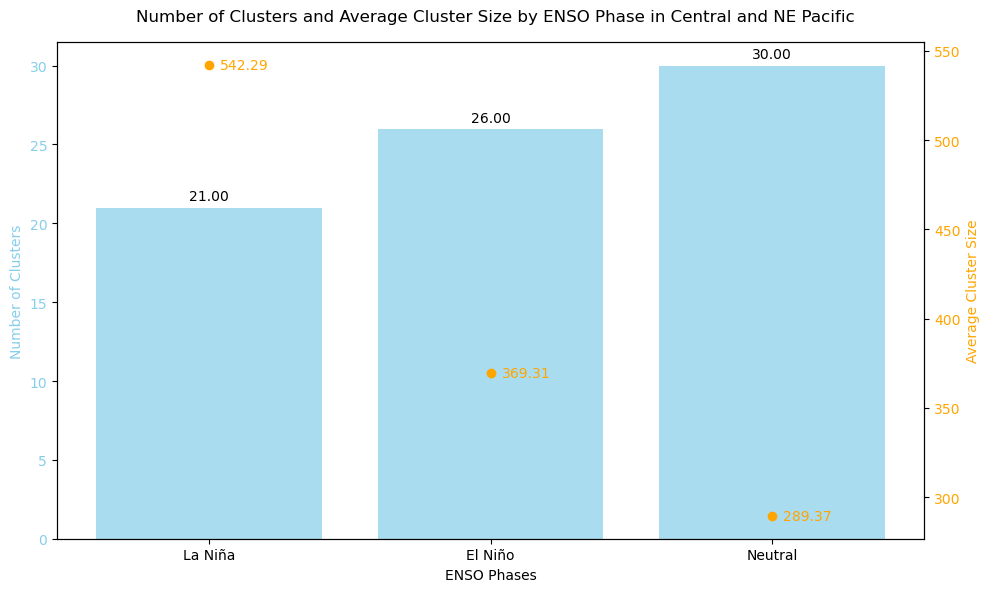

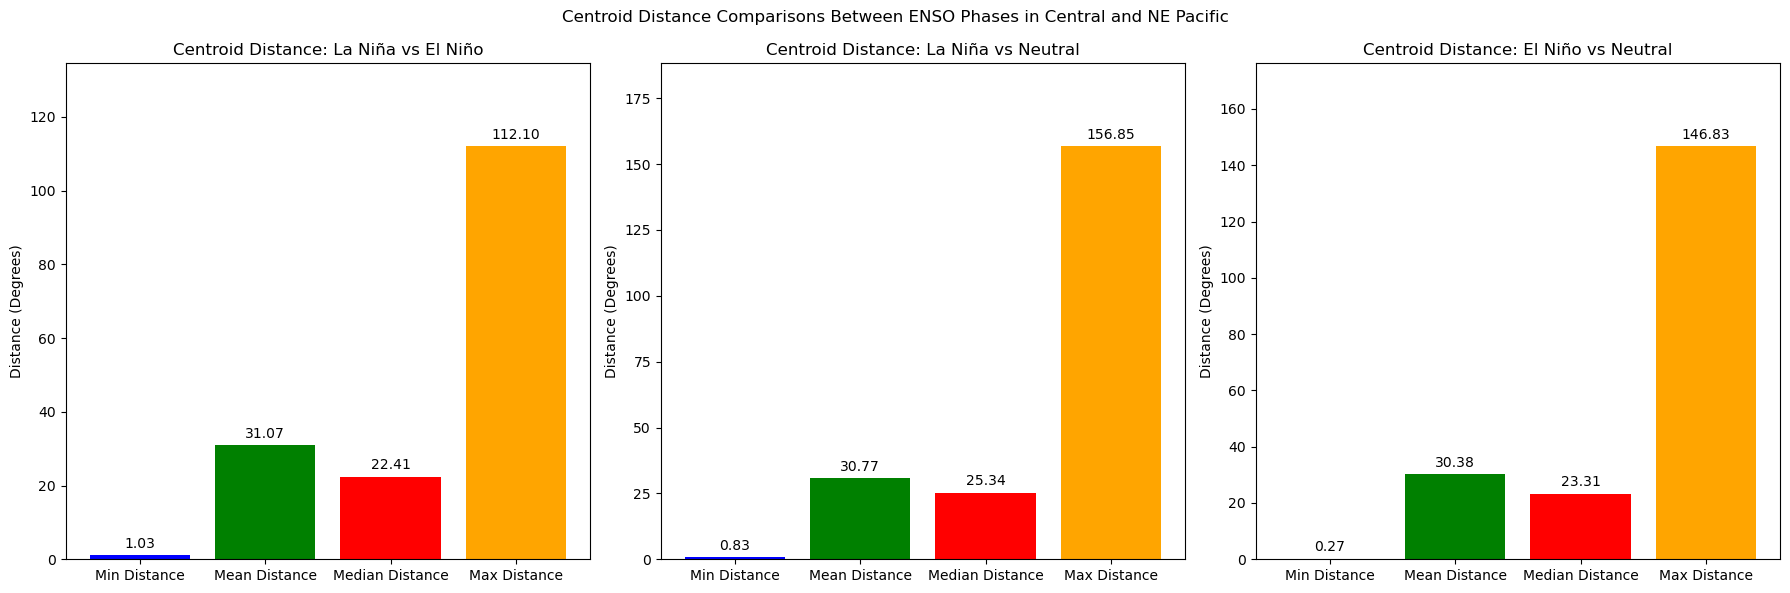

Number of La Niña Clusters: 21
Average La Niña Cluster Size: 542.29

Number of El Niño Clusters: 26
Average El Niño Cluster Size: 369.31

Number of Neutral Clusters: 30
Average Neutral Cluster Size: 289.37

Centroid Distance Comparisons:
La Niña vs El Niño:
  Mean Distance: 31.07
  Median Distance: 22.41
  Min Distance: 1.03
  Max Distance: 112.10

La Niña vs Neutral:
  Mean Distance: 30.77
  Median Distance: 25.34
  Min Distance: 0.83
  Max Distance: 156.85

El Niño vs Neutral:
  Mean Distance: 30.38
  Median Distance: 23.31
  Min Distance: 0.27
  Max Distance: 146.83



In [168]:
results, comparisons = compare_enso_phases_dbscan(nhc_enso, method='euclidean')
plot_centroid_model(results, comparisons, 'Central and NE')
print_enso_comparison(results, comparisons)

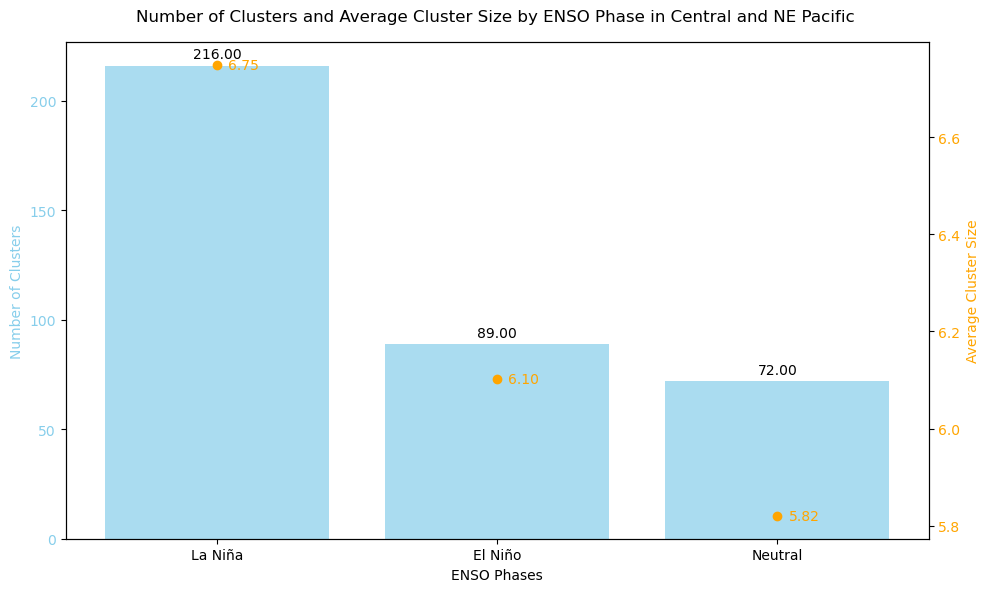

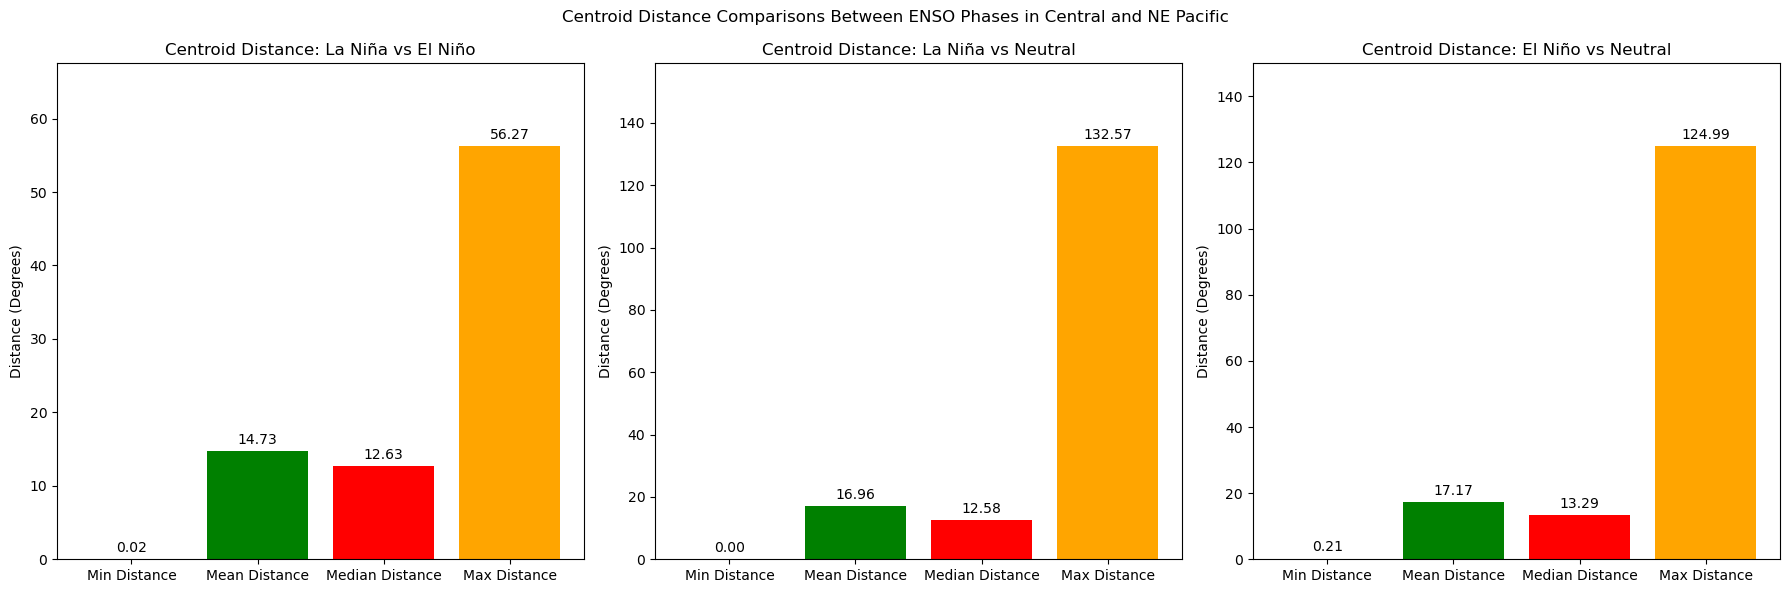

Number of La Niña Clusters: 216
Average La Niña Cluster Size: 6.75

Number of El Niño Clusters: 89
Average El Niño Cluster Size: 6.10

Number of Neutral Clusters: 72
Average Neutral Cluster Size: 5.82

Centroid Distance Comparisons:
La Niña vs El Niño:
  Mean Distance: 14.73
  Median Distance: 12.63
  Min Distance: 0.02
  Max Distance: 56.27

La Niña vs Neutral:
  Mean Distance: 16.96
  Median Distance: 12.58
  Min Distance: 0.00
  Max Distance: 132.57

El Niño vs Neutral:
  Mean Distance: 17.17
  Median Distance: 13.29
  Min Distance: 0.21
  Max Distance: 124.99



In [179]:
results, comparisons = compare_enso_phases_dbscan(nhc_enso, method='haversine', eps=10, min_samples=5)
plot_centroid_model(results, comparisons, 'Central and NE')
print_enso_comparison(results, comparisons)

#### Cluster Analysis for Central and NE Pacific

**Interpretation on number of clusters:**

The Neutral phase has the highest number of clusters (30), suggesting that tropical depressions (TDs) are more widely distributed across the Central and NE Pacific during Neutral years. This could indicate more variable atmospheric conditions that allow TDs to form in a broader range of locations.
The El Niño phase has a moderate number of clusters (26), indicating that while TDs are still fairly widespread, there may be slightly more focused areas of formation compared to Neutral years.
The La Niña phase has the fewest clusters (21), suggesting that during La Niña years, TDs tend to form in more concentrated areas, possibly due to more stable and predictable atmospheric patterns that limit the regions where TDs can develop.

**Interpretation of average cluster size:**

The La Niña phase has the largest average cluster size (542.29), indicating that when clusters do form during La Niña, they tend to be larger and potentially more impactful. This could reflect more robust or sustained conditions that support the development of larger systems.
The El Niño phase has a smaller average cluster size (369.31), which suggests that while TDs are still forming, they are generally more dispersed, leading to smaller clusters.
The Neutral phase has the smallest average cluster size (289.37), which aligns with the higher number of clusters. This suggests that during Neutral years, TDs may be more scattered and less intense, resulting in a greater number of smaller clusters.

#### Centroid Distance Comparisons for Central and NE Pacific

**La Niña vs El Niño:**

The centroid distances between La Niña and El Niño clusters show a moderate mean (31.07) and median (22.41) distance, indicating that while there are differences in the locations where TDs form during these phases, there is also some overlap.
The small minimum distance (1.03) suggests that in certain cases, TDs can form in very similar locations during both La Niña and El Niño phases. However, the large maximum distance (112.10) indicates that TDs can also form in significantly different regions depending on the phase, reflecting the different atmospheric and oceanic conditions associated with La Niña and El Niño.

**La Niña vs Neutral:**

The centroid distances between La Niña and Neutral phases are similar to those between La Niña and El Niño, with a mean of 30.77 and a median of 25.34. This suggests that while there are notable differences in where TDs tend to form, there is also some overlap, particularly in regions that are conducive to TD formation regardless of the ENSO phase.
The maximum distance (156.85) is the largest among all comparisons, indicating that during Neutral years, TDs can form in regions quite different from those during La Niña. This could reflect the more variable and less predictable nature of Neutral years, where the distribution of TDs is more spread out.

**El Niño vs Neutral**

The centroid distances between El Niño and Neutral phases are similar to the other comparisons, with a mean of 30.38 and a median of 23.31. This suggests that while El Niño and Neutral phases have differences in where TDs form, there is also some overlap, particularly in regions that are consistently favorable for TD formation.
The minimum distance (0.27) is very small, indicating that in some cases, TDs can form in almost the exact same locations during both phases. However, the maximum distance (146.83) suggests that there can also be significant shifts in where TDs form, likely reflecting the varying impacts of El Niño and Neutral conditions on atmospheric circulation patterns.

**Overall Summary:**

*La Niña Phase:* TDs during La Niña years tend to form in fewer, larger clusters, suggesting more concentrated areas of favorable conditions. The overlap with El Niño and Neutral phases is moderate, but there are also significant differences in where TDs form, reflecting the distinct atmospheric patterns associated with La Niña.

*El Niño Phase:* TDs during El Niño years are more dispersed, forming in a greater number of smaller clusters. The overlap with La Niña and Neutral phases suggests that while some regions remain favorable for TD formation across phases, El Niño conditions can also lead to shifts in where TDs are likely to develop.

*Neutral Phase:* The distribution of TDs during Neutral years is the most dispersed, with the highest number of clusters but the smallest average cluster size. This suggests that TDs are more spread out during Neutral years, with conditions that allow for TD formation across a broader range of locations. The centroid distances indicate that Neutral years can exhibit significant differences in TD formation locations compared to both La Niña and El Niño, likely due to the less predictable and more variable nature of Neutral conditions.

## Statistical Analysis

Statistical analysis is used to summarize and understand how various characteristics of tropical depressions are influenced by ENSO phases through SST anomalies. The data-driven insights generated through statistical analysis help answer key research questions about the relationship between ENSO and tropical depressions. The implemented below correlation analysis is a key statistical tool used to measure the strength and direction of relationships between SST anomalies and the characteristics of tropical depressions. Pearson correlations is defaut to be used but Spearman correlations is also available to evaluate these relationships.

### Pearson Correlation

The Pearson correlation coefficients provide measure of the strength and direction of the linear relationship between SST anomalies and various tropical depression (TD) characteristics (frequency, pressure, wind speed, latitude, and longitude) in the NW Pacific. 

In [165]:
def custom_wind_mean(series):
    """ 
    Computes the mean wind speed, excluding non-valid wind data (i.e., values less than or equal to 0).
    
    Parameters:
        series (Series): A Pandas Series containing wind speed values.
    Returns:
        float: The mean wind speed, or NaN if no valid values are present.
    """
    filtered_series = series[series > 0]
    if len(filtered_series) > 0:
        return filtered_series.mean()
    else:
        return np.nan

def custom_pressure_mean(series):
    """ 
    Computes the mean pressure, excluding non-valid pressure data (i.e., values less than or equal to 0).
    
    Parameters:
        series (Series): A Pandas Series containing pressure values.
    Returns:
        float: The mean pressure, or NaN if no valid values are present.
    """
    filtered_series = series[series > 0]
    if len(filtered_series) > 0:
        return filtered_series.mean()
    else:
        return np.nan

def combine_date_month(df):
    """ 
    Combines the 'year' and 'month' columns into a single 'date' column in YYYY-MM format, and sets this 
    as the index. The original 'year', 'month', and temporary 'date' columns are dropped.
    
    Parameters:
        df (DataFrame): A Pandas DataFrame containing 'year' and 'month' columns.
    Returns:
        DataFrame: The updated DataFrame with the combined 'date' column as the index.
    """
    df['date'] = [f'{df.year[i]}-0{df.month[i]}' if len(str(df.month[i])) == 1 else f'{df.year[i]}-{df.month[i]}' for i in df.index]
    
    df.date = pd.to_datetime(df.date)
    df.index = pd.Index(df.date)

    df = df.drop(columns=['year', 'month', 'date'])
    return df

def prepare_statistical_dataframe(df1, corr_period):
    """ 
    Aggregates the count of tropical depressions (TDs), mean pressure, and mean wind per month, 
    and merges the result with ONI (Oceanic Niño Index) monthly data. 
    
    Parameters:
        df1 (DataFrame): A DataFrame containing tropical depression data.
        corr_period (str): The correlation period ('m' for monthly, 'y' for yearly). 
    Returns:
        DataFrame: A DataFrame with aggregated statistics and merged ONI data.
    """

    if corr_period == 'm':
        df2 = oni_table
        query = [df1.index.year, df1.index.month]  # Group by year and month
    else:
        df2 = pd.DataFrame(enso_phase)
        query = [df1.index.year]  # Group by year only
    
    # Group by year and month, then aggregate
    df1 = df1.groupby(query).agg({
        'name': lambda x: list(pd.Series(x).unique()),  # List of unique storm names per month
        'min_pressure_mBar': custom_pressure_mean,  
        'max_wind_kn': custom_wind_mean,
        'lat': 'mean',
        'lon': 'mean',
    }).rename(columns={
        'name': 'unique_names',  # Store the list of unique storm names in 'unique_names'
        'min_pressure_mBar': 'average_min_pressure', 
        'max_wind_kn': 'average_max_wind',
        'lat': 'average_lat',
        'lon': 'average_lon'
    })

    # Count the number of unique names (storms) per month
    df1['frequency'] = df1['unique_names'].apply(len)

    # Reset the index and merge with ONI data if required
    if corr_period == 'm':
        df1.index.names = ['year', 'month']
        df1 = df1.reset_index()
        df1 = combine_date_month(df1)  # Combine year and month into a date column
    
    return pd.merge(df1, df2, on='date')  # Merge with ONI data

def perform_correlation(df, corr_period='m', corr_type='pearson', is_text_required=False):
    """ 
    Calculates the correlation between SST anomaly (from ONI) and various tropical depression variables, 
    such as frequency, pressure, wind speed, latitude, and longitude, using the specified correlation type.
    
    Parameters:
        df (DataFrame): A DataFrame with tropical depression statistics and ONI data.
        corr_period (str): The correlation period ('m' for monthly, 'y' for yearly).
        corr_type (str): The type of correlation to perform ('pearson' or 'spearman').
        is_text_required (bool): If True, returns the correlation results as a formatted text string. 
                                 If False, returns the results as a dictionary.
    Returns:
        dict or str: A dictionary of correlation results, or a formatted text string if is_text_required is True.
    """
    df = prepare_statistical_dataframe(df, corr_period)

    correlation = {
        'pearson': pearsonr,
        'spearman': spearmanr
    }
    if corr_period == 'm':
        # shifting the anomaly to align with the assumption that previous year anomaly affects this year TD season
        df['sst_anomaly'] = df['sst_anomaly'].shift(freq=pd.DateOffset(months=6))
        target_col = 'sst_anomaly'
    else:
        target_col = 'enso'
    
    df = df.dropna()

    output = {
            'corr_type': corr_type,
            'corr_period': corr_period,
            'Frequency': correlation[corr_type](df[target_col], df['frequency'])[0],
            'Pressure': correlation[corr_type](df[target_col], df['average_min_pressure'])[0],
            'Wind': correlation[corr_type](df[target_col], df['average_max_wind'])[0],
            'Latitude': correlation[corr_type](df[target_col], df['average_lat'])[0],
            'Longitude': correlation[corr_type](df[target_col], df['average_lon'])[0]
        }
    
    if not is_text_required:
        return output
    
    return (f"{corr_type[0].upper() + corr_type[1:]} Correlation\n"
            f"Frequency: {output['Frequency']}\n"
            f"Pressure: {output['Pressure']}\n"
            f"Wind: {output['Wind']}\n"
            f"Lat: {output['Latitude']}\n"
            f"Lon: {output['Longitude']}")

def plot_correlations(dfs=(jma_enso, nhc_enso), corr_period='m', corr_type='pearson'):
    """ 
    Calculates and plots correlation heatmaps for tropical depression variables and SST anomaly 
    for different ENSO phases (El Niño, La Niña, Neutral) in the Pacific Ocean, using Pearson or Spearman correlation.
    
    Parameters:
        dfs (tuple): Dataframes to correlate and compare
        corr_period (str): The correlation period ('m' for monthly, 'y' for yearly).
        corr_type (str): The type of correlation to plot ('pearson' or 'spearman').
    Returns:
        None: Displays the heatmap plots.
    """
    ocean_area = get_ocean_area_label()
    
    correlations = [perform_correlation(df, corr_period=corr_period, corr_type=corr_type) for df in dfs]   
    
    periods = {
        'm': 'Monthly',
        'y': 'Yearly'
    }

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    
    for i in range(2):
        data = correlations[i]
        period = periods[data['corr_period']]
        name = data['corr_type'][0].upper() + data['corr_type'][1:]

        # removing unwanted keys
        del data['corr_period']
        del data['corr_type']
        
        variables = [x for x in data.keys()]
        correlation_values = [x for x in data.values()]
        df = pd.DataFrame(correlation_values, index=variables, columns=[f'{name} Correlation'])
        sns.heatmap(df, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5, ax=axs[i], cbar=[True if i == 0 else False][0])
        axs[i].set_title(f'{name} {period} Correlation Heatmap for {ocean_area[i]} Pacific')
        
    plt.tight_layout()
    plt.show()

In [166]:
print(perform_correlation(nhc_enso, corr_period='m', corr_type='spearman', is_text_required=True))

Spearman Correlation
Frequency: 0.2980985555756191
Pressure: -0.14944443582146497
Wind: 0.11398440904697495
Lat: 0.23621563260033177
Lon: -0.35878100897794346


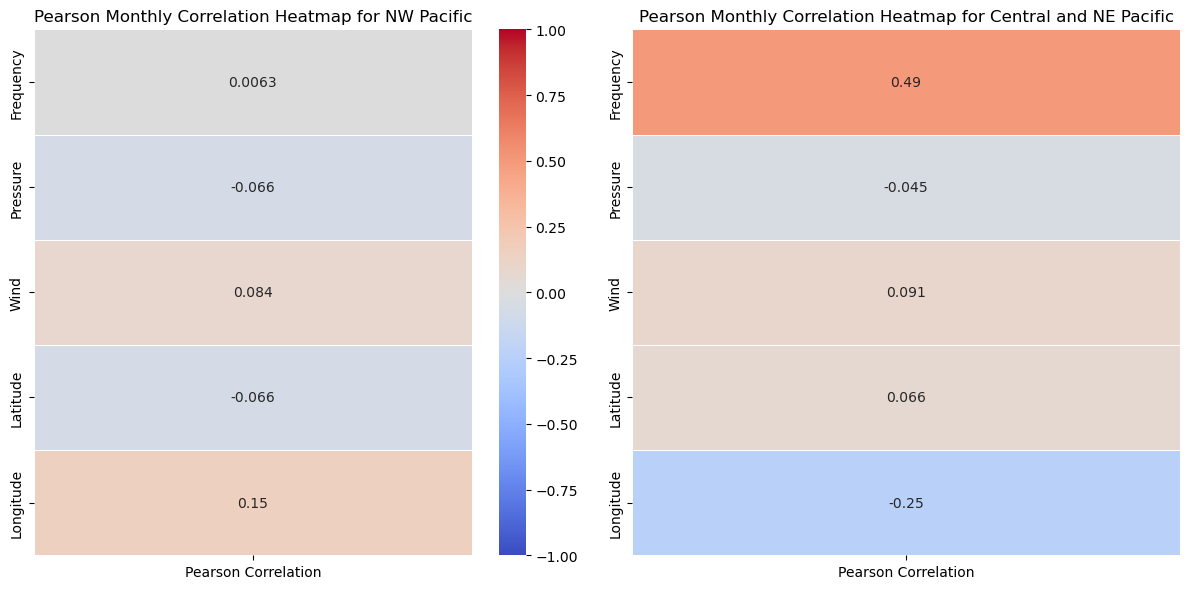

In [167]:
plot_correlations(corr_period='m', corr_type='pearson')

#### Pearson Correlation Results for NW Pacific

**Frequency:** There is almost no meaningful relationship between SST anomalies and the frequency of tropical depressions in the NW Pacific. While there is a slight positive correlation, it’s too weak to suggest a significant impact.

**Intensity (Pressure and Wind):** SST anomalies have very weak correlations with tropical depression intensity (both central pressure and wind speed). While higher SST anomalies might result in slightly stronger storms, the effect is minimal and likely overshadowed by other factors such as wind shear or atmospheric conditions.

**Position (Latitude and Longitude):** The weak negative correlation with **latitude** suggests that tropical depressions may form slightly closer to the equator during warmer SST periods, while the weak positive correlation with **longitude** indicates that they may form slightly further east. The longitudinal shift is the strongest correlation observed here and aligns with known El Niño patterns.

**Overall Summary:**

The correlations in the NW Pacific are all quite weak, indicating that SST anomalies have limited influence on tropical depression characteristics in this region. The most noticeable impact might be a small eastward shift in tropical depression formation during periods of higher SST anomalies, but other aspects like frequency, intensity, and latitude are not strongly affected.


#### Pearson Correlation Results for Central and NE Pacific

**Frequency:** The moderate positive correlation between SST anomalies and the frequency of tropical depressions indicates that El Niño conditions (warmer SSTs) in the Central and NE Pacific lead to an increase in the number of tropical depressions. This is the most significant relationship observed in the data, aligning with the established impact of El Niño on tropical storm formation in this region.

**Intensity (Pressure and Wind):** The correlations for central pressure and maximum wind speed are very weak, suggesting that SST anomalies have little influence on the intensity of tropical depressions in terms of either pressure or wind speed. While slightly stronger tropical depressions might form during El Niño years, other environmental factors likely play a more dominant role in determining intensity.

**Position (Latitude and Longitude):** The **latitude** correlation is weak, indicating minimal impact of SST anomalies on where tropical depressions form in terms of their north-south position.
The **longitude** correlation, though weak, indicates that tropical depressions tend to form further westward during higher SST anomalies, particularly during El Niño years. This westward shift is consistent with climatological patterns observed during El Niño events, where tropical storm activity in the NE Pacific tends to shift closer to the Central Pacific.

**Overall Summary:**

In the Central and NE Pacific, SST anomalies (particularly during El Niño events) have a moderate influence on the frequency of tropical depressions, leading to more storms during warmer periods. However, intensity measures like central pressure and wind speed are only weakly correlated with SST anomalies, suggesting that other factors likely drive storm intensity. The position of tropical depressions, particularly longitude, shows a weak but notable relationship, with storms tending to form further west during El Niño years. Overall, SST anomalies in this region are more closely tied to storm frequency than intensity or location.

### T-tests Comparative Analysis

t-tests are particularly useful to compare the means of tropical depression characteristics across different ENSO phases and to determine whether tropical depressions are significantly stronger or last longer in one phase compared to another. The tests will help quantify whether the differences are statistically significant.

**Significance Threshold** - a p-value threshold of 0.05 will be used. If the p-value is less than 0.05, the difference between the means of the two groups is considered statistically significant.

In [ ]:
def custom_pressure_min(series):
    """ 
    Computes the minimum pressure, excluding non-valid pressure data (i.e., values less than or equal to 0).
    
    Parameters:
        series (Series): A Pandas Series containing pressure values.
    Returns:
        float: The minimum pressure, or NaN if no valid values are present.
    """
    filtered_series = series[series > 0]
    if len(filtered_series) > 0:
        return filtered_series.min()
    else:
        return np.nan

def custom_wind_max(series):
    """ 
    Computes the maximum wind speed, excluding non-valid wind data (i.e., values less than or equal to 0).
    
    Parameters:
        series (Series): A Pandas Series containing wind speed values.  
    Returns:
        float: The maximum wind speed, or NaN if no valid values are present.
    """
    filtered_series = series[series > 0]
    if len(filtered_series) > 0:
        return filtered_series.max()
    else:
        return np.nan
    

def calculate_duration(df):
    """ 
    Calculates the duration of a tropical depression (TD) based on the index of the dataframe. 
    The duration is the difference between the maximum and minimum index values.
    
    Parameters:
        df (DataFrame): A Pandas DataFrame with the index representing time.   
    Returns:
        Timedelta: The duration of the tropical depression.
    """
    return df.index.max() - df.index.min()


def aggreagate_duration(df):
    """ 
    Aggregates tropical depression data by calculating the duration, minimum pressure, and maximum wind speed 
    for each tropical depression. Also includes the corresponding ENSO phase for each depression.
    
    Parameters:
        df (DataFrame): A DataFrame containing tropical depression data, including columns for pressure, wind, and ENSO phase.
    Returns:
        DataFrame: A DataFrame with aggregated tropical depression data, including duration, minimum pressure, 
                   maximum wind, and ENSO phase.
    """
    df = df.copy()
    df['duration'] = pd.Series()
    
    df = df.groupby([df.index.year, df.name]).agg({
        'duration':  calculate_duration,
        'min_pressure_mBar': custom_pressure_min,
        'max_wind_kn': custom_wind_max,
        'enso': 'min'
    })

    df['duration'] = df['duration'].dt.total_seconds() / 3600
    
    df = df.reset_index()
    df.index = pd.Index(df.date)
    df = df.drop(columns='date')

    df = df.dropna()

    return df

def ttest(df, phases_arr=(1, -1), test='w', equal_var=False):
    """ 
    Performs a t-test to compare tropical depression metrics (wind intensity, pressure, or duration) between two 
    specified ENSO phases. Optionally plots the result.
    
    Parameters:
        df (DataFrame): A DataFrame with aggregated tropical depression data, including duration, pressure, wind, and ENSO phase.
        phases_arr (tuple): A tuple of two ENSO phases to compare (default: (1, -1) for El Niño vs La Niña).
        test (str): The metric to test ('w' for wind intensity, 'p' for pressure, 'd' for duration).
        equal_var (bool): Whether to assume equal variance for the t-test (default: False).
    Returns:
        None: Prints the t-test result and optionally plots it.
    """
    phases = get_phase_names()
    
    test_type_mapper = {
        'w': 'Wind Intensity',
        'p': 'Pressure Intensity',
        'd': 'Duration',
    }
    
    test_mapper = {
        'w': 'max_wind_kn',
        'p': 'min_pressure_mBar',
        'd': 'duration',
    }

    df = aggreagate_duration(df)
  
    df1 = df[df.enso == phases_arr[0]]
    df2 = df[df.enso == phases_arr[1]]
    
    t_stat, p_value = ttest_ind(df1[test_mapper[test]], df2[test_mapper[test]], equal_var=equal_var)

    print(f"T-test for {test_type_mapper[test]} ({phases[phases_arr[0]]} vs {phases[phases_arr[1]]}): t-stat = {t_stat}, p-value = {p_value}")

In [ ]:
ttest(jma_enso, (1, -1))
ttest(jma_enso, (1, 0))
ttest(jma_enso, (-1, 0))

#### T-tests Results for the NW Pacific 

The following analysis breaks down the t-test results for tropical depressions' wind intensity, pressure intensity, and duration across the three ENSO phases. The t-tests compare the means between two groups at a time, with the t-statistic indicating the magnitude of the difference, and the p-value determining if the difference is statistically significant.

**Wind Intensity (Maximum Wind Speed)**

1. El Niño vs. La Niña:
t-stat: 1.814
p-value: 0.070 (Not significant)

The mean wind intensity during El Niño years is slightly higher than during La Niña years (positive t-statistic). However, the difference is not statistically significant, with a p-value of 0.070. The result is close to significance, indicating there might be a weak effect, but it’s not strong enough to be conclusive.

2. El Niño vs. Neutral:
t-stat: -0.602
p-value: 0.547 (Not significant)

The mean wind intensity during El Niño years is slightly lower than during Neutral years (negative t-statistic). However, the difference is not statistically significant (p-value of 0.547). This suggests that wind intensity is similar between El Niño and Neutral years.

3. La Niña vs. Neutral:
t-stat: -2.444
p-value: 0.015 **(Significant)**

The mean wind intensity during La Niña years is significantly lower than during Neutral years. The negative t-statistic indicates that storms are less intense during La Niña, and the p-value of 0.015 confirms this difference is statistically significant. This suggests that tropical depressions during La Niña are noticeably weaker in terms of wind intensity compared to Neutral years.

In [ ]:
ttest(jma_enso, (1, -1), 'p')
ttest(jma_enso, (1, 0), 'p')
ttest(jma_enso, (-1, 0), 'p')

**Pressure Intensity (Minimum Central Pressure)**

1. El Niño vs. La Niña:
t-stat: -1.760
p-value: 0.079 (Not significant)

The mean pressure intensity (with lower pressures indicating stronger storms) during La Niña years is slightly lower than during El Niño years, meaning tropical depressions may be slightly stronger during La Niña (negative t-statistic). However, this difference is not statistically significant, with a p-value of 0.079, suggesting only a weak trend.

2. El Niño vs. Neutral:
t-stat: 0.818
p-value: 0.413 (Not significant)

The mean pressure intensity during El Niño years is slightly higher (weaker depressions) compared to Neutral years (positive t-statistic). However, the difference is not statistically significant (p-value of 0.413), suggesting that there’s no meaningful difference in pressure intensity between El Niño and Neutral years.

3. La Niña vs. Neutral:
t-stat: 2.618
p-value: 0.009 **(Significant)**

The mean pressure during La Niña years is significantly higher (indicating weaker storms) compared to Neutral years. The positive t-statistic and significant p-value (0.009) suggest that tropical depressions during La Niña are noticeably weaker in terms of pressure intensity compared to Neutral years.

In [ ]:
ttest(jma_enso, (1, -1), 'd')
ttest(jma_enso, (1, 0), 'd')
ttest(jma_enso, (-1, 0), 'd')

**Duration of Tropical Depressions**

1. El Niño vs. La Niña:
t-stat: -0.591
p-value: 0.555 (Not significant)

The mean duration of tropical depressions during El Niño years is slightly shorter than during La Niña years (negative t-statistic), but this difference is not statistically significant (p-value of 0.555). Therefore, the duration of tropical depressions does not seem to vary much between these two phases.

2. El Niño vs. Neutral:
t-stat: -2.444
p-value: 0.015 **(Significant)**

The mean duration of tropical depressions during El Niño years is significantly shorter compared to Neutral years. The negative t-statistic indicates a shorter duration during El Niño, and the p-value of 0.015 confirms this difference is statistically significant.

3. La Niña vs. Neutral:
t-stat: -0.636
p-value: 0.525 (Not significant)

The mean duration of tropical depressions during La Niña years is slightly shorter than during Neutral years (negative t-statistic), but the difference is not statistically significant (p-value of 0.525). Thus, there is no meaningful difference in tropical depression duration between La Niña and Neutral years.

**Conclusion:**

The results suggest that tropical depressions in the NW Pacific tend to be weaker in terms of wind intensity and pressure during La Niña years compared to Neutral years. Additionally, tropical depressions during El Niño years are shorter in duration compared to those in Neutral years. However, no significant differences were observed between El Niño and La Niña in terms of wind intensity, pressure, or duration. These findings highlight the moderate influence of ENSO phases on tropical depression characteristics in the NW Pacific.

In [ ]:
ttest(nhc_enso, (1, -1))
ttest(nhc_enso, (1, 0))
ttest(nhc_enso, (-1, 0))

#### T-tests Results for Central and NE Pacific

This analysis examines the t-test results for the wind intensity, pressure intensity, and duration of tropical depressions across the three ENSO phases in the Central and NE Pacific.

**Wind Intensity (Maximum Wind Speed)**

1. El Niño vs. La Niña:
t-stat: -0.399
p-value: 0.690 (Not significant)

The mean wind intensity during El Niño years is slightly lower than during La Niña years (negative t-statistic). However, with a p-value of 0.690, this difference is not statistically significant. This means that wind intensities are relatively similar between El Niño and La Niña in the Central and NE Pacific.

2. El Niño vs. Neutral:
t-stat: -1.761
p-value: 0.079 (Not significant)

The mean wind intensity during El Niño years is slightly lower than during Neutral years (negative t-statistic). However, the p-value of 0.079 is not statistically significant but close to the 0.05 threshold. There may be a weak trend suggesting slightly stronger wind intensities during Neutral phases compared to El Niño, but it’s not 
conclusive.

3. La Niña vs. Neutral:
t-stat: -1.518
p-value: 0.130 (Not significant)

The mean wind intensity during La Niña years is slightly lower than during Neutral years. However, the p-value of 0.130 is not statistically significant, suggesting that there is no meaningful difference in wind intensity between these two phases in the Central and NE Pacific.

In [ ]:
ttest(nhc_enso, (1, -1), 'p')
ttest(nhc_enso, (1, 0), 'p')
ttest(nhc_enso, (-1, 0), 'p')

**Pressure Intensity (Minimum Central Pressure)**

1. El Niño vs. La Niña:
t-stat: 0.454
p-value: 0.650 (Not significant)

The mean pressure intensity during El Niño years is slightly higher than during La Niña years (positive t-statistic). However, with a p-value of 0.650, this difference is not statistically significant. This suggests that tropical depression pressure intensities in the Central and NE Pacific do not vary meaningfully between El Niño and La Niña.

2. El Niño vs. Neutral:
t-stat: 1.882
p-value: 0.061 (Not significant)

The mean pressure intensity during El Niño years is slightly higher (indicating weaker depressions) compared to Neutral years (positive t-statistic). The p-value of 0.061 is just above the 0.05 threshold, suggesting a weak trend toward weaker tropical depressions during El Niño compared to Neutral years, but the difference is not conclusive.

3. La Niña vs. Neutral:
t-stat: 1.593
p-value: 0.112 (Not significant)

The mean pressure intensity during La Niña years is slightly higher than during Neutral years (positive t-statistic), indicating that tropical depressions might be slightly weaker during La Niña. However, with a p-value of 0.112, this difference is not statistically significant.

In [ ]:
ttest(nhc_enso, (1, -1), 'd')
ttest(nhc_enso, (1, 0), 'd')
ttest(nhc_enso, (-1, 0), 'd')

**Duration of Tropical Depressions**

1. El Niño vs. La Niña:
t-stat: 1.024
p-value: 0.306 (Not significant)

The mean duration of tropical depressions during El Niño years is slightly longer than during La Niña years (positive t-statistic). However, with a p-value of 0.306, this difference is not statistically significant. Therefore, the duration of tropical depressions does not appear to differ meaningfully between El Niño and La Niña.

2. El Niño vs. Neutral:
t-stat: 0.095
p-value: 0.924 (Not significant)

The mean duration of tropical depressions during El Niño years is almost identical to the duration during Neutral years (very small t-statistic). The p-value of 0.924 confirms that there is no significant difference in duration between these two phases.

3. La Niña vs. Neutral:
t-stat: -0.934
p-value: 0.351 (Not significant)

The mean duration of tropical depressions during La Niña years is slightly shorter than during Neutral years (negative t-statistic). However, with a p-value of 0.351, this difference is not statistically significant.

**Conclusion:**

Overall, in the Central and NE Pacific, there is no strong evidence of significant differences in the wind intensity, pressure intensity, or duration of tropical depressions across ENSO phases. However, there are some weak trends suggesting that tropical depressions might be slightly weaker (higher pressure) during El Niño and possibly have stronger winds during Neutral years compared to El Niño.

## Summary of Hypotheses Testing for the Effects of ENSO on TDs in the North Pacific Oceans

This project aimed to investigate the impact of ENSO (El Niño, La Niña, and Neutral phases) on tropical depressions (TDs) across the Northwest (NW) Pacific and Central/Northeast (NE) Pacific. By testing four key hypotheses, it was sought to understand how ENSO phases affect the frequency, intensity, track, and duration of TDs. The following conclusions are drawn based on statistical analysis, including correlations, t-tests, and density mapping.

### Hypothesis 1: ENSO and Frequency of TDs

- Null Hypothesis $H_0$: There is **no significant difference** in the frequency of tropical depressions across different ENSO phases (El Niño, La Niña, Neutral).
- Alternative Hypothesis $H_1$: There **is a significant difference** in the frequency of tropical depressions across different ENSO phases.

**NW Pacific:**

Neutral years had the highest TD frequency (26.59 TDs/year), while El Niño years had the lowest (23.84 TDs/year). However, statistical analysis showed no significant difference between ENSO phases, leading to the **acceptance of the null hypothesis**.

**Central/NE Pacific:**

La Niña years exhibited the highest TD frequency (15.33 TDs/year), while El Niño years had the lowest (14.16 TDs/year). The correlation between ENSO phases and TD frequency was more pronounced in this region, suggesting a significant influence of La Niña on increased TD activity. Therefore, the **null hypothesis is rejected** in the Central/NE Pacific, supporting a significant influence of ENSO on TD frequency.

### Hypothesis 2: ENSO and Intensity of TDs

- Null Hypothesis $H_0$: ENSO phases **do not** significantly affect the intensity of tropical depressions (measured by metrics such as maximum wind speed or minimum central pressure).
- Alternative Hypothesis $H_1$: ENSO phases significantly affect the intensity of tropical depressions.

**NW Pacific:**

The mean wind speed and minimum central pressure varied slightly between ENSO phases, with Neutral years showing the highest intensity (mean wind speed: 117.14 knots). However, t-tests indicated no statistically significant differences between ENSO phases, meaning that the **null hypothesis is accepted**.

**Central/NE Pacific:**

There was no significant difference in TD intensity across ENSO phases, despite higher variability in wind speed during El Niño years. The statistical tests showed that ENSO does not significantly influence TD intensity in this region. Therefore, the **null hypothesis is accepted**.

### Hypothesis 3: ENSO and Tracks of TDs

- Null Hypothesis $H_0$: ENSO phases **do not** significantly affect the track of tropical depressions.
- Alternative Hypothesis $H_1$: ENSO phases significantly affect the track of tropical depressions.

**NW Pacific:**

Density mapping and cluster analysis revealed substantial shifts in TD tracks between ENSO phases. El Niño years saw TDs lingering east and west of the Philippines, while La Niña years shifted TD tracks toward Japan. Cluster analysis showed significant spatial differences between ENSO phases, supporting the **rejection of the null hypothesis** in favor of ENSO having a significant effect on TD tracks.

**Central/NE Pacific:**

During El Niño years, TDs tended to move westward toward Hawaii, while La Niña years saw a higher concentration near Mexico. Cluster and centroid distance analysis confirmed distinct differences in TD tracks across ENSO phases. Thus, the **null hypothesis is rejected**, confirming that ENSO significantly influences TD tracks in the Central/NE Pacific.

### Hypothesis 4: ENSO and Duration of TDs

- Null Hypothesis $H_0$: ENSO phases **do not** significantly affect the duration of tropical depressions.
- Alternative Hypothesis $H_1$: ENSO phases significantly affect the duration of tropical depressions.

**NW Pacific:**

No significant differences in TD duration were observed between ENSO phases based on t-tests. Although the duration was slightly shorter during El Niño years, the differences were not statistically significant. Therefore, the **null hypothesis is accepted**, indicating no significant influence of ENSO on TD duration in the NW Pacific.

**Central/NE Pacific:**

Similarly, no significant differences in TD duration were observed between ENSO phases in this region. The statistical tests showed that ENSO phases do not significantly impact TD duration, leading to the **acceptance of the null hypothesis**.

### Overall Conclusions

In this project, the impact of the El Niño-Southern Oscillation (ENSO) on tropical depressions (TDs) across the Northwest Pacific and Central/Northeast Pacific was analyzed. The research sought to evaluate how ENSO phases—El Niño, La Niña, and Neutral—affect the frequency, intensity, track, and duration of tropical depressions through statistical methods, including correlation analysis, t-tests, and density mapping. The results demonstrated that ENSO phases have a significant impact on the frequency and tracks of TDs, particularly in the Central/NE Pacific, where La Niña years showed the highest TD frequency and more westward TD tracks compared to El Niño years, which led to a higher likelihood of TD formation closer to Hawaii . In contrast, the NW Pacific exhibited fewer significant changes in frequency and intensity across ENSO phases, though La Niña was associated with stronger storms and shifts in TD tracks toward Japan .

The findings align with existing literature, which highlights that ENSO influences the location and timing of tropical cyclone formation, with El Niño shifting activity eastward and La Niña resulting in more storms in the western Pacific . However, despite notable shifts in storm tracks, there was little evidence of a strong correlation between ENSO phases and the intensity or duration of TDs, confirming that other environmental factors, such as wind shear and atmospheric pressure patterns, may have a more substantial role in determining TD strength . These insights provide valuable contributions to understanding the complex relationship between climate oscillations and tropical depressions, supporting more accurate storm forecasting and disaster preparedness strategies in ENSO-affected regions.

## Data Analysis Technics Used in the Project 

### Kernel Density Estimation (KDE)

KDE is a non-parametric statistical technique used to estimate the probability density function of a continuous random variable. Unlike histograms, which provide a discrete approximation of the data’s distribution, KDE provides a smooth, continuous curve to represent the underlying data distribution. This smoothness allows KDE to show patterns and densities in the data more clearly.

**How KDE Works:**
KDE works by placing a "kernel" (a smooth, bell-shaped function, typically Gaussian) at each data point and summing these kernels to produce an overall estimate of the density. The width of the kernel is controlled by a parameter called bandwidth, which determines how much the kernels overlap. A larger bandwidth results in a smoother density estimate, while a smaller bandwidth shows more detail but might capture noise in the data.

**KDE in this Project:**
In this project, KDE was used to visualize the spatial density of tropical depressions (TDs) across the Pacific during different ENSO phases. By plotting KDE maps, we can identify regions with higher concentrations of TD occurrences. The color intensity in these KDE plots represents the density of TD tracks or formation points, helping us compare how the distribution of storms shifts during El Niño, La Niña, and Neutral phases. For example, high-density areas in the KDE plot show where tropical depressions are more likely to occur or intensify, giving insights into how ENSO phases influence the spatial behavior of storms.

### DBSCAN (Density-Based Spatial Clustering of Applications with Noise) 

DBSCAN is a clustering algorithm used in data science to identify groups of data points (clusters) based on their density. Unlike traditional clustering algorithms like K-means, which rely on defining a fixed number of clusters, DBSCAN automatically determines the number of clusters and can detect outliers (noise) that don’t belong to any cluster.

**How DBSCAN Works:**
- Core Points: A core point is a point that has at least a certain number of other points (defined by the parameter min_samples) within a specified distance (eps). These points form the dense regions that will become clusters.
- Border Points: A border point is within the neighborhood of a core point but does not have enough neighbors to be a core point itself.
- Noise Points: Points that are neither core points nor within the neighborhood of any core point are labeled as noise or outliers.

**Parameters of DBSCAN:**
- eps (epsilon): The maximum distance between two points for one to be considered in the neighborhood of the other.
- min_samples: The minimum number of points required to form a dense region (i.e., a cluster).

**DBSCAN in This Project:**
In this project, DBSCAN was used to identify clusters of tropical depressions (TDs) in different ENSO phases across the Northwest Pacific and Central/Northeast Pacific. By applying DBSCAN, we were able to:
- Cluster TD Tracks: Group tropical depressions based on their spatial proximity, identifying areas where TDs tend to cluster during El Niño, La Niña, and Neutral phases.
- Compare ENSO Phases: Compare the number, size, and location of clusters between ENSO phases. For instance, we observed more clusters during El Niño years, suggesting a more dispersed formation pattern, while La Niña showed fewer, more concentrated clusters.
DBSCAN helped provide a clear quantitative and visual understanding of how tropical depression activity changes spatially in response to ENSO phase shifts.

### Pearson Correlation

Pearson correlation measures the linear relationship between two continuous variables. It assumes that both variables are normally distributed and that the relationship between them is linear. The correlation coefficient (r) ranges from -1 to 1:

r = 1: Perfect positive linear correlation (as one variable increases, the other increases).
r = -1: Perfect negative linear correlation (as one variable increases, the other decreases).
r = 0: No linear correlation between the variables.

**Usage in the Project:**

In this project, Pearson correlation was used to assess the strength and direction of the relationship between ENSO phases (as indicated by SST anomalies) and various tropical depression (TD) characteristics:

- Frequency of TDs: Correlating the number of TDs during different ENSO phases to understand how events like El Niño or La Niña affect storm occurrence.
- Intensity (Wind/Pressure): Examining how SST anomalies influence the maximum wind speed or minimum central pressure of TDs, indicating the impact on storm strength.
- Geographical Position (Lat/Lon): Exploring how the location of TDs (in terms of latitude and longitude) is influenced by ENSO phases.
- 
In particular, Pearson correlation was valuable for understanding the linear relationship between SST anomalies and TD activity, identifying weak or moderate correlations in different regions of the Pacific.

Spearman Correlation
Spearman correlation is a non-parametric measure of rank correlation. It assesses the monotonic relationship between two variables, which means that if one variable increases, the other variable consistently increases (or decreases), but not necessarily in a linear fashion. Spearman's correlation is useful when the data are not normally distributed or when the relationship is not linear.

Spearman was not the primary method used in this project but could be applied for analyzing relationships when data show non-linear trends.

### T-tests

T-tests are statistical tests used to determine whether there is a significant difference between the means of two groups. In this project, t-tests were used to compare the characteristics of tropical depressions (TDs) across different ENSO phases (El Niño, La Niña, and Neutral). Specifically, t-tests help assess whether tropical depression frequency, intensity (wind speed, pressure), or duration differ significantly between these phases.

**Types of T-Tests:**
- Independent Two-Sample T-Test: Compares the means of two independent groups, such as the intensity of tropical depressions during El Niño and La Niña years.
- One-Sample T-Test: Compares the sample mean with a known value (not used in this project).
- Paired T-Test: Compares means from the same group at different times (not applicable here).

**Usage in the Project:**
- Wind Intensity: T-tests were applied to compare the maximum wind speeds of TDs, averaged per year, during different ENSO phases (e.g., El Niño vs. La Niña). The results indicated whether there were significant differences in storm strength across phases.
- Pressure Intensity: T-tests helped assess whether the minimum central pressures of TDs, averaged per year, differed significantly across ENSO phases, showing how storm intensity varied.
- Duration: T-tests compared the duration of tropical depressions between ENSO phases, highlighting any significant differences in how long storms lasted.

**Output:**
The t-statistic measures the difference between group means relative to the variation in data.
The p-value indicates whether the observed differences are statistically significant. A p-value below 0.05 suggests a significant difference between the two groups.

## References

### Links
- [Climate Prediction Center](https://origin.cpc.ncep.noaa.gov/products/precip/CWlink/MJO/enso.shtml#history)
- [National Hurricane Center](https://www.nhc.noaa.gov/data/)
- [Japan Meteorology Agency](https://www.jma.go.jp/jma/jma-eng/jma-center/rsmc-hp-pub-eg/trackarchives.html)
- [NASA EarthData](https://urs.earthdata.nasa.gov/home)
- [National Centers for Environmental Information](https://www.ncei.noaa.gov/)
- [National Data Buoy Center](https://www.ndbc.noaa.gov/)
- [National Oceanic and Atmospheric Administration](https://www.noaa.gov/)
- [Climate Reanalyzer](https://climatereanalyzer.org/)
- [YouTube](https://www.youtube.com/)
- [Wikipedia](https://www.wikipedia.org/)
- [ChatGPT](https://chatgpt.com/)
### Books
- **Meteorology For Seafarers** by Lieutenant-Commander R.M. Frampton and P.A. Uttridge